<!DOCTYPE html>
<html>
<head>
    <style>
        body {
            font-family: Arial, sans-serif;
            line-height: 1.6;
            color: #333;
        }
        h1 {
            color: #2F4F4F;
        }
        h2 {
            color: #4682B4;
        }
        p {
            margin: 10px 0;
        }
        .key-points, .open-questions {
            background-color: #F0F8FF;
            padding: 15px;
            border-left: 5px solid #4682B4;
            margin-bottom: 20px;
        }
        .key-points ul, .open-questions ul {
            margin: 0;
            padding-left: 20px;
        }
        .highlight {
            color: #B22222;
            font-weight: bold;
        }
          div {
            margin: 10px 0;
        }
    </style>
</head>
<body>

<h1 style="color: #2F4F4F;">1. Summary of the Approach</h1>
<p>In this notebook, I tackled the ARC challenge by framing it as a sequence-to-sequence (seq2seq) translation task, similar to translating from English to French. Here, the input grids and output grids are treated as sequences that need to be translated from one form to another. This approach leverages the power of transformer architectures, which have proven highly effective in language translation tasks.</p>

<div class="key-points">
    <h2 style="color: #4682B4;">Key Points of the Approach:</h2>
    <ul>
        <li><span class="highlight">Data Preparation:</span> The input and output grids are pre-processed to ensure consistent dimensions. The grids are padded to a fixed size (30x30), and various augmentations such as rotation are applied to diversify the training data.</li>
        <li><span class="highlight">Custom Transformer Model:</span> The model consists of separate encoder and decoder layers, designed to handle categorical data. Each grid cell is represented as a category, and the model uses <code>nn.Embedding</code> layers to convert these categorical values into dense embeddings. Additionally, positional encodings are added to represent the 2D spatial positions of grid cells.</li>
        <li><span class="highlight">Start and End Tokens:</span> To help the model understand the beginning and end of sequences, I introduced special tokens (<code>&lt;START&gt;</code> and <code>&lt;END&gt;</code>), similar to techniques used in NLP tasks.</li>
        <li><span class="highlight">Training:</span> The model is trained with a relatively high dropout rate of 0.4, which helps in regularization and prevents overfitting. Surprisingly, the model shows promising results during training, effectively learning to translate input grids to output grids.</li>
    </ul>
</div>

<h1 style="color: #2F4F4F;">2. Issue with Inference</h1>
<p>While the training phase of the model shows great promise with effective learning and generalization, the inference phase does not perform as expected. This discrepancy might stem from the way the transformer model is implemented for this grid-based problem. Although I initially treated the task as a sequence-to-sequence translation problem, similar to language translation, this approach may not be the most suitable for handling 2D grid transformations. The specific requirements and nuances of grid-based reasoning might require a different architecture or handling mechanism that I haven't fully determined yet.</p>

<div style="background-color: #F0F8FF; padding: 15px; border-left: 5px solid #4682B4; margin-bottom: 20px;">
    <h2 style="color: #4682B4;">Key Points to Consider:</h2>
    <ul>
        <li><span style="color: #B22222; font-weight: bold;">Possible Misalignment with Grid-Based Problem:</span> The current model might not correctly capture the spatial relationships and transformations required for grid tasks. The way positional encodings and embeddings are applied during inference might not fully align with the structure of grid data.</li>
        <li><span style="color: #B22222; font-weight: bold;">Reconsideration of Inference Approach:</span> Unlike typical transformer tasks, starting inference with a <code>&lt;START&gt;</code> token may not be the best strategy for grid-based tasks. An alternative approach could involve a one-shot inference technique, where the model predicts the entire grid output in one go, rather than sequentially. However, the exact implementation of such an approach remains unclear.</li>
        <li><span style="color: #B22222; font-weight: bold;">Potential Use of Patches as in Vision Transformers:</span> Another idea could be to treat parts of the grid as patches, similar to the Vision Transformer (ViT) approach, and process them in parallel to capture spatial dependencies more effectively. This would require a redesign of the model architecture to handle grid patches.</li>
        <li><span style="color: #B22222; font-weight: bold;">Inconsistent Performance Between Training and Inference:</span> It's puzzling that the model performs so well during training but fails to generalize effectively during inference. This inconsistency could indicate an issue with overfitting to the training data, or it might suggest that the model hasn't fully learned the underlying spatial patterns required for unseen data.</li>
    </ul>
</div>


<h1 style="color: #2F4F4F;">3. Reflection: Not the Path to AGI, but a Step Towards It</h1>
<p>While this approach is not the definitive way to achieve Artificial General Intelligence (AGI), it is a small but meaningful step towards exploring how transformers and other deep learning techniques can be applied to grid-based reasoning tasks. The process of framing a grid transformation task as a sequence-to-sequence problem allows us to harness the strengths of transformers while identifying their limitations in such domains.</p>

<p>Through this work, I aim to contribute to the broader discussion on the versatility of transformers and their applicability beyond traditional NLP tasks. The challenges faced here also underscore the need for more specialized architectures that can handle grid-based and spatial reasoning tasks more effectively.</p>

<div class="open-questions">
    <h2>Open Questions:</h2>
    <ul>
        <li>Why does the model excel during training with a relatively high dropout rate of 0.4, but struggles significantly during inference? Is this due to overfitting to the training data, or is there a fundamental flaw in how the model processes grid data during inference?</li>
    </ul>
    <p>I'm eager to hear thoughts from the community on what might be going wrong and suggestions on the right approach to solve grid-based problems using transformer architectures.</p>
</div>

</body>
</html>


## Imports

In [44]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
import json
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from termcolor import colored
import math
import random
import matplotlib.pyplot as plt

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = "cpu"

KAGGLE = False
DEBUG = False

NUM_CLASSES = 10
IGNORE_CLASS = 0
START_TOKEN = NUM_CLASSES   # 10
END_TOKEN = NUM_CLASSES + 1 # 11
SEP_TOKEN = NUM_CLASSES + 2 # 12

## Default Seeds

In [45]:
# Set seed for PyTorch
torch.manual_seed(42)

# If using CUDA
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)  # if you are using multi-GPU.

# Set seed for NumPy
np.random.seed(42)

# Set seed for Python's built-in random library
random.seed(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [46]:
def log_message(message: str, color: str = "black"):
    if DEBUG:
        print(colored(message, color))


def log_with_condition(message: str, condition=False, color: str = "blue"):
    if condition:
        print(colored(message, color))


def log_important(message: str, color: str = "blue"):
    print(colored(message, color))


def log_error(message: str, color: str = "red"):
    print(message, color)

In [47]:
colors = [
    [0, 0, 0],
    [0, 116, 217],
    [255, 65, 54],
    [46, 204, 64],
    [255, 220, 0],
    [170, 170, 170],
    [240, 18, 190],
    [255, 133, 27],
    [127, 219, 255],
    [135, 12, 37],
]


def paint(*matrices):
    num_matrices = len(matrices)
    fig, axes = plt.subplots(1, num_matrices, figsize=(3 * num_matrices, 2))

    if num_matrices == 1:
        axes = [axes]  # Ensure axes is a list even for a single subplot

    for i, matrix in enumerate(matrices):
        matrix[matrix < 0] = 0
        matrix[matrix > 9] = 9
        try:
            # Ensure matrix is a 2D array
            m, n = matrix.shape
            print(f"Matrix {i} shape: {m, n}")
            unique_values = np.unique(matrix)
            print(f"Unique values in matrix {i}: {unique_values}")

            # Convert matrix values to corresponding colors, ignoring -1
            matrix_colored = np.array(
                [
                    [
                        colors[element] if element != -1 else [255, 255, 255]
                        for element in row
                    ]
                    for row in matrix
                ]
            )
            axes[i].imshow(matrix_colored, interpolation='nearest')
            axes[i].set_title(f'({m} x {n})')
            axes[i].axis('off')
        except Exception as ex:
            print(f"Error processing matrix {i}: {ex}")
            pass

    plt.tight_layout()
    plt.show()

In [48]:
def pad_to_dimensions(grid, target_size, ignore_class=IGNORE_CLASS):
    h, w = grid.shape[0], grid.shape[1]

    # Calculate padding to match target_size
    pad_bottom = target_size[0] - h
    pad_right = target_size[1] - w

    # Pad within the original dimensions with zeros
    padded_grid = np.pad(
        grid,
        ((0, pad_bottom), (0, pad_right)),
        mode='constant',
        constant_values=IGNORE_CLASS,
    )

    # Pad the rest to maximum size of 30x30 with ignore_class
    max_size = (30, 30)
    if padded_grid.shape[0] < max_size[0] or padded_grid.shape[1] < max_size[1]:
        pad_bottom = max_size[0] - padded_grid.shape[0]
        pad_right = max_size[1] - padded_grid.shape[1]
        padded_grid = np.pad(
            padded_grid,
            ((0, pad_bottom), (0, pad_right)),
            mode='constant',
            constant_values=ignore_class,
        )

    return padded_grid

In [49]:
def rotate_grid(grid, angle):
    if angle == 0:
        return grid
    elif angle == 90:
        return np.rot90(grid, k=1, axes=(1, 0)).tolist()
    elif angle == 180:
        return np.rot90(grid, k=2, axes=(1, 0)).tolist()
    elif angle == 270:
        return np.rot90(grid, k=3, axes=(1, 0)).tolist()
    else:
        raise ValueError(
            "Unsupported rotation angle. Supported angles are 0, 90, and 270 degrees."
        )

In [50]:
def pad_to_final_size(grid, final_size=(30, 30), ignore_class=IGNORE_CLASS):
    h, w = grid.shape[0], grid.shape[1]

    # Calculate padding to match final_size
    pad_bottom = final_size[0] - h
    pad_right = final_size[1] - w

    # Pad within the original dimensions with zeros
    padded_grid = np.pad(
        grid,
        ((0, pad_bottom), (0, pad_right)),
        mode='constant',
        constant_values=ignore_class,
    )

    return padded_grid

In [51]:
def shift_grid(grid, step_right=0, step_down=0):
    """
    Shift the grid right and down by the specified steps, filling new cells with zeros.

    Args:
    grid (numpy.ndarray): The input grid to be shifted.
    step_right (int): The number of columns to shift right.
    step_down (int): The number of rows to shift down.

    Returns:
    numpy.ndarray: The shifted grid.

    Example usage:
    grid = np.array([[1, 2, 3,0], [4, 5, 6,0], [7, 8, 9,0],[0, 0, 0,0]])
    shifted_grid = shift_grid(grid, step_right=1, step_down=0)
    print(shifted_grid)
    """
    h, w = grid.shape
    shifted_grid = np.zeros_like(grid)

    # Shift right
    if step_right > 0:
        shifted_grid[:, step_right:] = grid[:, :-step_right]
    else:
        shifted_grid[:, :] = grid[:, :]

    # Shift down
    if step_down > 0:
        shifted_grid[step_down:, :] = shifted_grid[:-step_down, :]
        shifted_grid[:step_down, :] = 0
    else:
        shifted_grid[:, :] = shifted_grid[:, :]

    return shifted_grid

In [52]:
def scale_up_grid(grid, scale_factor):
    # Scale up a grid by repeating its elements along both axes.
    # Repeat elements `scale_factor` times along the row (axis=0) and column (axis=1).
    return np.repeat(np.repeat(grid, scale_factor, axis=0), scale_factor, axis=1)


def custom_zoom(input_grid, final_size=30):
    # Custom zoom function to scale the input grid up to a specified final size.
    # The input grid is scaled proportionally to the maximum dimension.

    # Determine the largest dimension (width or height) of the input grid.
    max_dim = max(input_grid.shape)

    # Calculate the scaling factor to ensure the larger dimension fits within the final size.
    scale_factor = final_size // max_dim

    # Scale up the input grid using the calculated scaling factor.
    scaled_input_grid = scale_up_grid(input_grid, scale_factor)

    # If the scaled grid does not match the final desired size (30x30 by default),
    # pad the grid to match the final size using the `pad_to_final_size` function.
    if scaled_input_grid.shape != (final_size, final_size):
        scaled_input_grid = pad_to_final_size(scaled_input_grid)

    # Return the scaled (and potentially padded) grid.
    return scaled_input_grid


def downscale_grid(grid, target_size):
    # Downscale a grid to a target size by taking the most frequent element (mode)
    # in each non-overlapping block of the original grid.

    # Determine the original size (height and width) of the input grid.
    original_size = grid.shape

    # Calculate the scaling factors for both dimensions (width and height).
    scale_factor_x = original_size[1] // target_size[1]  # Horizontal scaling factor
    scale_factor_y = original_size[0] // target_size[0]  # Vertical scaling factor

    # Initialize a new grid with the target size filled with zeros.
    downscaled_grid = np.zeros(target_size, dtype=grid.dtype)

    # Iterate through each block of the grid to downscale it to the target size.
    for i in range(target_size[0]):
        for j in range(target_size[1]):
            # Extract a block from the original grid that corresponds to the current position.
            block = grid[
                i * scale_factor_y : (i + 1) * scale_factor_y,
                j * scale_factor_x : (j + 1) * scale_factor_x,
            ]

            # Find the most frequent element (mode) in the current block and assign it to the downscaled grid.
            downscaled_grid[i, j] = np.bincount(block.flatten()).argmax()

    # Return the downscaled grid.
    return downscaled_grid

In [53]:
def load_data(challenges_path, solutions_path):
    with open(challenges_path, 'r') as f:
        challenges = json.load(f)
    with open(solutions_path, 'r') as f:
        solutions = json.load(f)
    
    for task_id in challenges.keys():
        solution = solutions[task_id][0]
        challenges[task_id]['test'][0]['output'] = solution

    return challenges

## Our Transformer Implementation

In [54]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=7200):
        super(PositionalEncoding, self).__init__()
        self.encoding = self.generate_encoding(d_model, max_len)
        self.inference_encoding = self.generate_inference_encoding(d_model)

    def generate_encoding(self, d_model, max_len):
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )
        encoding = torch.zeros(max_len, d_model)
        encoding[:, 0::2] = torch.sin(position * div_term)
        encoding[:, 1::2] = torch.cos(position * div_term)
        encoding = encoding.unsqueeze(0)
        return encoding

    def generate_inference_encoding(self, d_model, height=30, width=30):
        num_positions = height * width
        position = torch.arange(0, num_positions).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )
        encoding = torch.zeros(num_positions, d_model)
        encoding[:, 0::2] = torch.sin(position * div_term)
        encoding[:, 1::2] = torch.cos(position * div_term)
        # encoding = encoding.view(1, height, width, d_model)  # Reshape for 2D grid
        encoding = encoding.unsqueeze(0)

        return encoding

    def forward(self, x, mode="training"):
        log_message(f"x shape: {x.shape}")
        x = x.reshape(1, -1, 256)

        if x.dim() == 2:
            x = x.unsqueeze(1)
            print(f"x unsqueeze shape: {x.shape}")

        try:
            x = x + self.encoding[:, : x.size(1), : x.size(2)].to(x.device)
        except:
            print(f"x shape: {x.shape}")
            print(f"x size shape: {x.size}")
            print(
                f"x self.encoding[:, :x.size(1), :x.size(2)] shape: {self.encoding[:, :x.size(1), :x.size(2)].shape}"
            )

        return x

In [55]:
class CustomTransformerCategorical(nn.Module):
    def __init__(
        self,
        d_model,
        num_categories,
        nhead,
        num_encoder_layers,
        num_decoder_layers,
        dim_feedforward,
        dropout_rate=0.1,
    ):
        super(CustomTransformerCategorical, self).__init__()
        # Accounting for <start> and <end> tokens
        self.num_categories = num_categories + 3

        # Embedding layer for categories
        self.grid_embedding = nn.Embedding(self.num_categories, d_model)
        self.grid_positional_encoding = PositionalEncoding(d_model)
        self.grid_positional_encoding_inference = PositionalEncoding(
            d_model, max_len=30 * 30
        )
        self.d_model = d_model

        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=self.d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout_rate,
            ),
            num_layers=num_encoder_layers,
        )

        self.decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(
                d_model=self.d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout_rate,
            ),
            num_layers=num_decoder_layers,
        )

        self.fc_out = nn.Linear(
            self.d_model, self.num_categories
        )  # Output layer for categories
        self.dropout = nn.Dropout(dropout_rate)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz), 1).transpose(0, 1)
        mask = (
            mask.float()
            .masked_fill(mask == 1, float('-inf'))
            .masked_fill(mask == 0, float(0.0))
        )
        return mask
    
    def forward(self, encoder_ins, decoder_in, src_mask=None, tgt_mask=None):
        memories = []
        for sample in encoder_ins:
            # Embedding and positional encoding for encoder sequence
            encoder_emb = self.grid_embedding(sample)
            encoder_emb = self.dropout(encoder_emb)  # Apply dropout after embedding
            encoder_emb_pos = self.grid_positional_encoding(encoder_emb)

            # Encoder
            memory = self.encoder(encoder_emb_pos.transpose(0, 1), src_key_padding_mask=src_mask)
            memories.append(memory)
        
        encoder_mem = torch.mean(torch.stack(memories), dim=0)

        # Embedding and positional encoding for output grids
        decoder_emb = self.grid_embedding(decoder_in)
        decoder_emb = self.dropout(decoder_emb)
        decoder_emb_pos = self.grid_positional_encoding(decoder_emb)

        # decoder input SEP 及之前的长度
        decoder_mem_length = decoder_in.tolist().index(SEP_TOKEN)

        log_message(f'encoder_in shape: {encoder_ins[0].shape}, encoder_mem shape: {encoder_mem.shape}', 'yellow')
        log_message(f'decoder_in shape: {decoder_in.shape}, mem length: {decoder_mem_length}, emb shape: {decoder_emb_pos.transpose(0, 1).shape}', 'yellow')

        # tgt_mask 上三角矩阵
        if tgt_mask is None:
            tgt_mask = self.generate_square_subsequent_mask(decoder_emb_pos.size(1)).to(DEVICE)
            # print(tgt_mask)

        # Decoder
        transformer_output = self.decoder(
            decoder_emb_pos.transpose(0, 1),
            encoder_mem,
            tgt_mask=tgt_mask,
            memory_key_padding_mask=src_mask,
        )[decoder_mem_length:]
        log_message(f'transformer_output shape: {transformer_output.shape}', 'yellow')

        transformer_output = self.dropout(transformer_output)

        # Logits for categories
        output = self.fc_out(transformer_output.transpose(0, 1))

        return output

    # TODO 改写 predict
    def predict(self, encoder_ins, decoder_in):
        self.eval()
        with torch.no_grad():
            memories = []
            for sample in encoder_ins:
                # Embedding and positional encoding for encoder sequence
                encoder_emb = self.grid_embedding(sample)
                encoder_emb = self.dropout(encoder_emb)  # Apply dropout after embedding
                encoder_emb_pos = self.grid_positional_encoding(encoder_emb)

                # Encoder
                memory = self.encoder(encoder_emb_pos.transpose(0, 1), src_key_padding_mask=None)
                memories.append(memory)
            
            encoder_mem = torch.mean(torch.stack(memories), dim=0)

            # initialize output grids <start> ... <sep>
            output_grids = decoder_in.reshape(1, -1).to(DEVICE)

            # Decode the output grid
            for _ in range(0, 901):
                output_emb = self.grid_embedding(output_grids)
                output_emb = self.grid_positional_encoding(output_emb)
                transformer_output = self.decoder(
                    output_emb.transpose(0, 1),
                    encoder_mem
                )
                output_logits = self.fc_out(transformer_output.transpose(0, 1))

                next_token = torch.argmax(output_logits[:, -1, :], dim=-1, keepdim=True)
                output_grids = torch.cat([output_grids, next_token], dim=1)

                if next_token.item() == END_TOKEN:
                    break

            output_grids = output_grids.squeeze().cpu().numpy()

            return output_grids

In [56]:
def add_special_tokens_to_grids(grid1, grid2):
    return [START_TOKEN] + grid1 + [SEP_TOKEN] + grid2 + [END_TOKEN]

def prepare_inference_data_with_special_tokens(grid):
    tokens = [START_TOKEN] + grid.flatten().tolist() + [SEP_TOKEN]
    return torch.tensor(tokens, dtype=torch.long).to(DEVICE)

def prepare_label_data_with_end_token(label_grid):
    label_grid_flat = label_grid.flatten().tolist()
    tokens = label_grid_flat + [END_TOKEN]
    return torch.tensor(tokens, dtype=torch.long).to(DEVICE)

def prepare_encoder_data_with_tokens(input_grids, output_grids):
    all_data = []

    for input_grid, output_grid in zip(input_grids, output_grids):
        # Flatten the input and output grids
        input_grid_flat = input_grid.flatten().tolist()
        output_grid_flat = output_grid.flatten().tolist()

        # Add start and end tokens
        tokens = add_special_tokens_to_grids(input_grid_flat, output_grid_flat)

        # Convert to tensors
        all_data.append(torch.tensor(tokens, dtype=torch.long).to(DEVICE))

    return all_data

def prepare_decoder_data_with_tokens(input_grid, output_grid):
    # Flatten the input and output grids
    input_grid_flat = input_grid.flatten().tolist()
    output_grid_flat = output_grid.flatten().tolist()

    # Add start and end tokens, remove END
    tokens = add_special_tokens_to_grids(input_grid_flat, output_grid_flat)[:-1]

    # Convert to tensor
    return torch.tensor(tokens, dtype=torch.long).to(DEVICE)

In [57]:
def transformer_initialize_weights(m):
    if isinstance(m, nn.Linear):
        # Standard initialization as above
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.zeros_(m.bias)
    elif isinstance(m, nn.LayerNorm):
        # Specifically zeroing bias here
        if m.bias is not None:
            init.zeros_(m.bias)

In [58]:
def train_model(dataset, model, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for step, (_, data) in enumerate(dataset.items()):
            optimizer.zero_grad()

            # Encoder data
            encoder_inputs = [custom_zoom(np.array(x['input'], dtype=np.int32)) for x in data['train']]
            encoder_outputs = [custom_zoom(np.array(x['output'], dtype=np.int32)) for x in data['train']]

            # List[num_samples, seq_length]
            encoder_tokens = prepare_encoder_data_with_tokens(encoder_inputs, encoder_outputs)

            # Decoder data
            decoder_inputs = custom_zoom(np.array(data['test'][0]['input'], dtype=np.int32))
            decoder_outputs = custom_zoom(np.array(data['test'][0]['output'], dtype=np.int32))
            decoder_tokens = prepare_decoder_data_with_tokens(decoder_inputs, decoder_outputs)

            output_logits = model(encoder_tokens, decoder_tokens) # [1, 901, 13]
            log_message(f'output logits shape: {output_logits.shape}', 'blue')

            if step % 20 == 0:
                predictions = torch.argmax(output_logits, dim=-1).cpu().detach().numpy() # [1, 901]
                log_message(f' > raw predictions shape: {predictions.shape}')

                predictions = predictions[0][:-1] # remove END for paint
                # predictions = predictions[0][1:]
                actual_outputs = decoder_outputs.flatten()

                log_message(f' > actual: {actual_outputs}')
                paint(
                    predictions.reshape(30, 30),
                    actual_outputs.reshape(30, 30),
                )

            # Compute loss using the logits and true class indices
            loss = criterion(
                output_logits.view((-1, NUM_CLASSES + 3)),
                # output_logits[:, :-1, :].view((-1, NUM_CLASSES + 3)),
                prepare_label_data_with_end_token(decoder_outputs)
                # torch.tensor(decoder_outputs.flatten(), dtype=torch.long).to(DEVICE)
            )  # Flatten to match shapes

            loss.backward()
            optimizer.step()

            if step % 10 == 0:  # Print progress every 10 steps
                print(
                    f'Epoch [{epoch + 1}/{num_epochs}], Step [{step}/{len(dataset)}], Loss: {loss.item():.4f}'
                )

In [59]:
if KAGGLE:
    train_challenges_path = '/kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'
    train_solutions_path = '/kaggle/input/arc-prize-2024/arc-agi_training_solutions.json'
    eval_challenges_path = '/kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json'
    eval_solutions_path = '/kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json'
    submission_path = '/kaggle/working/submission.json'
else:
    train_challenges_path = './data/arc-agi_training_challenges.json'
    train_solutions_path = './data/arc-agi_training_solutions.json'
    eval_challenges_path = './data/arc-agi_evaluation_challenges.json'
    eval_solutions_path = './data/arc-agi_evaluation_solutions.json'
    submission_path = 'submission.json'

train_data = load_data(train_challenges_path, train_solutions_path)
val_data = load_data(eval_challenges_path, eval_solutions_path)

num_categories = NUM_CLASSES  # Number of categories (0-9)

In [60]:
def reset_cuda_memory():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

In [61]:
# Define the model, loss function, and optimizer
num_categories = 10

if 'model' in globals():
    try:
        del model
        reset_cuda_memory()
    except:
        pass

model = CustomTransformerCategorical(
    256,  # Match the embedding dimension
    num_categories,
    nhead=4,  # 8,6,6
    num_encoder_layers=4,
    num_decoder_layers=4,
    dim_feedforward=2048,
    dropout_rate=0.4,
).to(DEVICE)

model.apply(transformer_initialize_weights)
model

/home/gyc/.pyenv/versions/kaggle/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


CustomTransformerCategorical(
  (grid_embedding): Embedding(13, 256)
  (grid_positional_encoding): PositionalEncoding()
  (grid_positional_encoding_inference): PositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.4, inplace=False)
        (linear2): Linear(in_features=2048, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.4, inplace=False)
        (dropout2): Dropout(p=0.4, inplace=False)
      )
    )
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerDecoderLayer(
        (se

In [62]:
# Calculate weight for classes
from sklearn.utils.class_weight import compute_class_weight

all_values = []
for task in train_data.values():
    test_grid = task['test'][0]['output']
    for col in test_grid:
        all_values.extend(col)

class_weights = compute_class_weight('balanced', classes=np.unique(all_values), y=np.array(all_values))
mean_weight = np.mean(class_weights)
train_weights = class_weights.tolist() + [mean_weight] * 3   # special tokens

train_weights = torch.tensor(train_weights, dtype=torch.float).to(DEVICE)
print(train_weights)

# train_weights = None

tensor([0.1873, 1.3325, 1.6487, 1.1992, 1.2117, 2.1811, 3.8511, 5.9985, 1.6948,
        5.9032, 2.5208, 2.5208, 2.5208], device='cuda:0')


In [63]:
criterion = nn.CrossEntropyLoss(weight=train_weights)  # For categorical output
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 4 5 6 7 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 7]


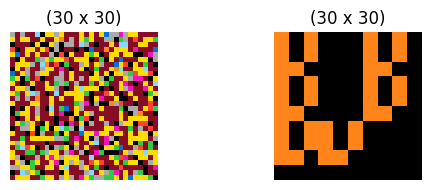

Epoch [1/5], Step [0/400], Loss: 4.9742
Epoch [1/5], Step [10/400], Loss: 5.7566
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 4 5 6 7 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1]


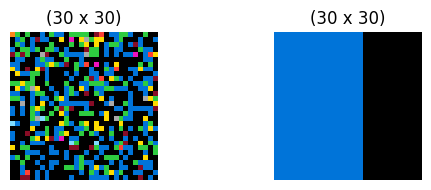

Epoch [1/5], Step [20/400], Loss: 1.9734
Epoch [1/5], Step [30/400], Loss: 4.4766
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 5 6 7 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 3 4 7]


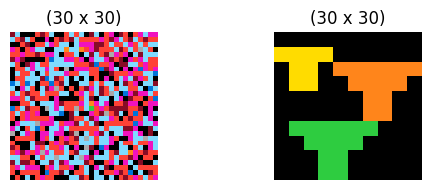

Epoch [1/5], Step [40/400], Loss: 4.8335
Epoch [1/5], Step [50/400], Loss: 2.4808
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 4 5 6 7 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2 3 4 5 6 7 8 9]


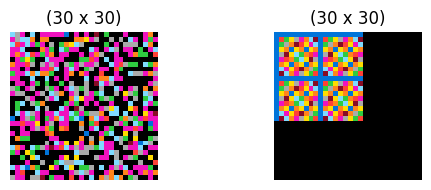

Epoch [1/5], Step [60/400], Loss: 3.4515
Epoch [1/5], Step [70/400], Loss: 2.6668
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 4 5 6 7 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 8]


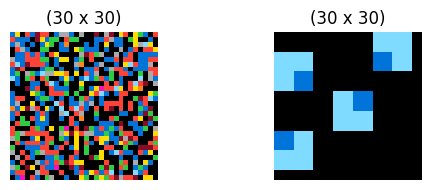

Epoch [1/5], Step [80/400], Loss: 3.0174
Epoch [1/5], Step [90/400], Loss: 3.0631
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 4 5 6 7 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2]


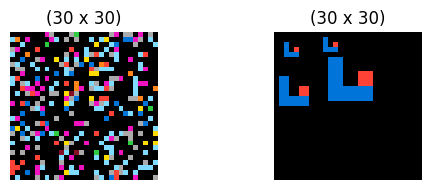

Epoch [1/5], Step [100/400], Loss: 2.2265
Epoch [1/5], Step [110/400], Loss: 1.8318
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 4 5 6 7 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 7]


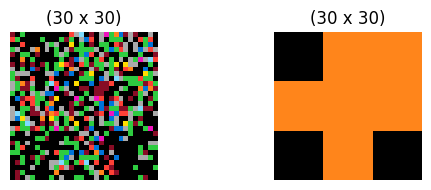

Epoch [1/5], Step [120/400], Loss: 3.5691
Epoch [1/5], Step [130/400], Loss: 1.2656
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 4 5 6 7 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 6]


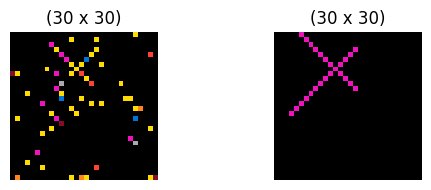

Epoch [1/5], Step [140/400], Loss: 1.8274
Epoch [1/5], Step [150/400], Loss: 1.6144
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 4 6 7]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 6]


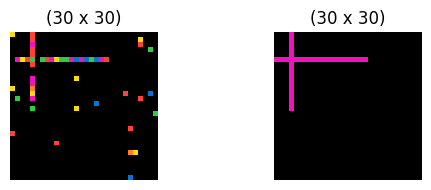

Epoch [1/5], Step [160/400], Loss: 1.9437
Epoch [1/5], Step [170/400], Loss: 0.5378
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 4 7 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 4 8]


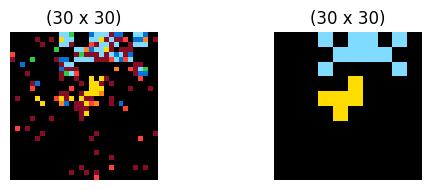

Epoch [1/5], Step [180/400], Loss: 1.6798
Epoch [1/5], Step [190/400], Loss: 1.3699
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 4 5 6 7 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 4 8]


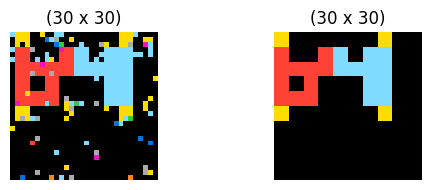

Epoch [1/5], Step [200/400], Loss: 0.9427
Epoch [1/5], Step [210/400], Loss: 0.6601
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 3 4 5 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 8]


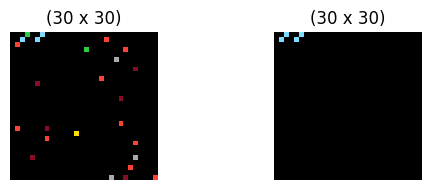

Epoch [1/5], Step [220/400], Loss: 0.4409
Epoch [1/5], Step [230/400], Loss: 1.0440
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 4 5 6 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 3 5 6 8]


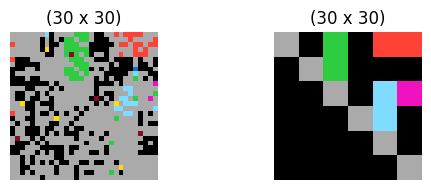

Epoch [1/5], Step [240/400], Loss: 1.4382
Epoch [1/5], Step [250/400], Loss: 0.6205
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 4 6 7]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2]


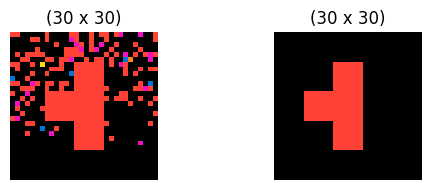

Epoch [1/5], Step [260/400], Loss: 0.5187
Epoch [1/5], Step [270/400], Loss: 0.4979
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 3 4 5 6 7 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 4 6]


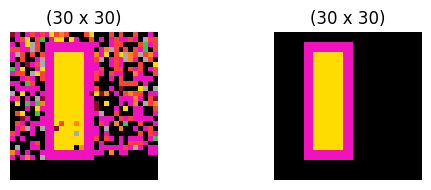

Epoch [1/5], Step [280/400], Loss: 1.5211
Epoch [1/5], Step [290/400], Loss: 0.1458
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 4 6 7 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2 3 4 6 7 8 9]


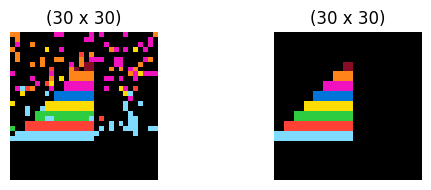

Epoch [1/5], Step [300/400], Loss: 0.7362
Epoch [1/5], Step [310/400], Loss: 0.3275
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 4 5 6 7 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 4 9]


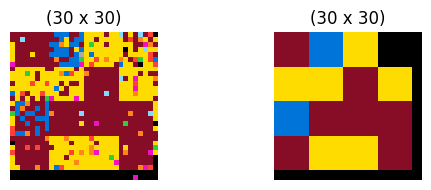

Epoch [1/5], Step [320/400], Loss: 0.7551
Epoch [1/5], Step [330/400], Loss: 1.7569
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 5 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2 8]


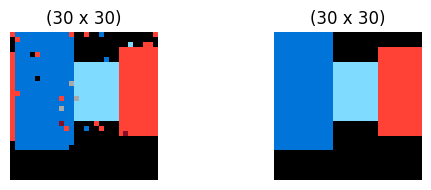

Epoch [1/5], Step [340/400], Loss: 0.5639
Epoch [1/5], Step [350/400], Loss: 0.5561
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 3]


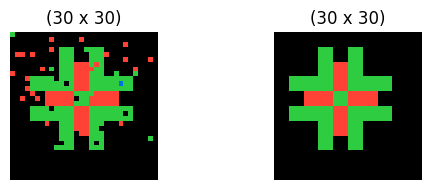

Epoch [1/5], Step [360/400], Loss: 0.9268
Epoch [1/5], Step [370/400], Loss: 0.5388
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 3 6 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 9]


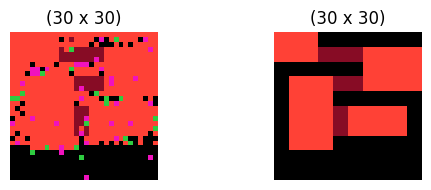

Epoch [1/5], Step [380/400], Loss: 1.0594
Epoch [1/5], Step [390/400], Loss: 0.6667
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 6 7 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 7]


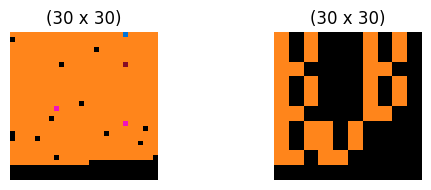

Epoch [2/5], Step [0/400], Loss: 0.2823
Epoch [2/5], Step [10/400], Loss: 1.0416
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 3 4 6 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1]


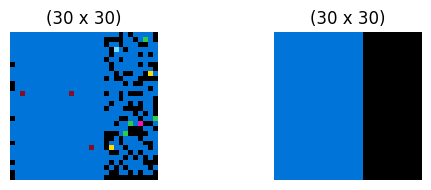

Epoch [2/5], Step [20/400], Loss: 0.2690
Epoch [2/5], Step [30/400], Loss: 0.2890
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 3 4 6 7 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 3 4 7]


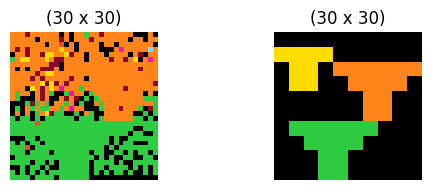

Epoch [2/5], Step [40/400], Loss: 0.6661
Epoch [2/5], Step [50/400], Loss: 0.8217
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 4 5 6 7 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2 3 4 5 6 7 8 9]


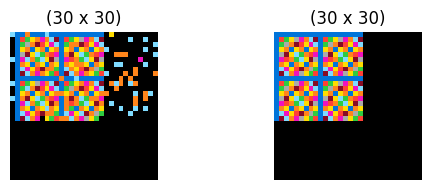

Epoch [2/5], Step [60/400], Loss: 4.6938
Epoch [2/5], Step [70/400], Loss: 0.5849
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 4 6 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 8]


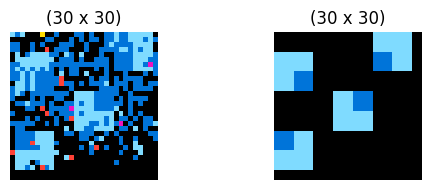

Epoch [2/5], Step [80/400], Loss: 1.0477
Epoch [2/5], Step [90/400], Loss: 1.2767
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 4]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2]


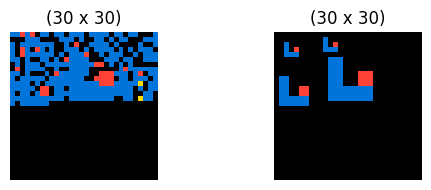

Epoch [2/5], Step [100/400], Loss: 0.6722
Epoch [2/5], Step [110/400], Loss: 0.2769
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 4 5 6 7 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 7]


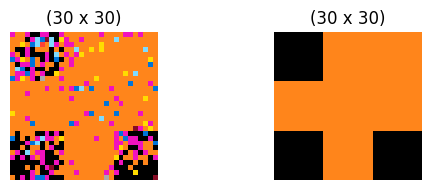

Epoch [2/5], Step [120/400], Loss: 0.5304
Epoch [2/5], Step [130/400], Loss: 0.5573
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 6 7]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 6]


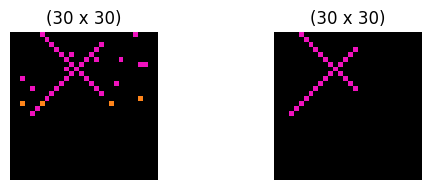

Epoch [2/5], Step [140/400], Loss: 1.6910
Epoch [2/5], Step [150/400], Loss: 0.9888
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 5 6]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 6]


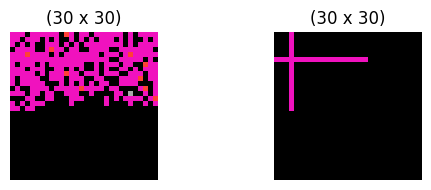

Epoch [2/5], Step [160/400], Loss: 0.7066
Epoch [2/5], Step [170/400], Loss: 0.3768
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 4 6 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 4 8]


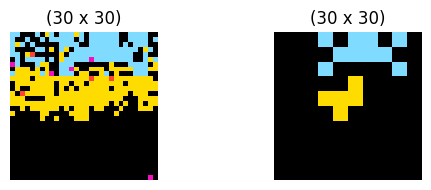

Epoch [2/5], Step [180/400], Loss: 0.6341
Epoch [2/5], Step [190/400], Loss: 1.2728
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 4 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 4 8]


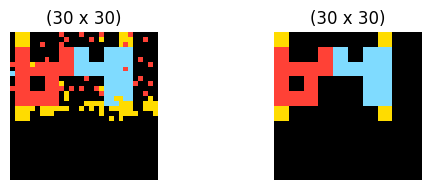

Epoch [2/5], Step [200/400], Loss: 0.6788
Epoch [2/5], Step [210/400], Loss: 0.4539
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 7 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 8]


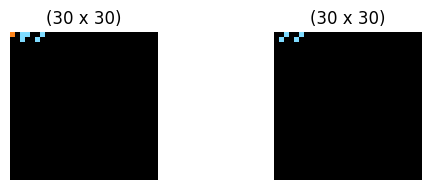

Epoch [2/5], Step [220/400], Loss: 0.1698
Epoch [2/5], Step [230/400], Loss: 0.9330
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 3 4 5 6 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 3 5 6 8]


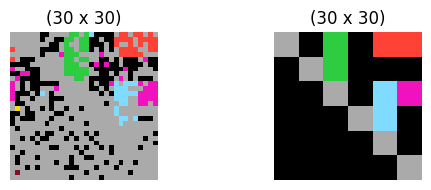

Epoch [2/5], Step [240/400], Loss: 1.0314
Epoch [2/5], Step [250/400], Loss: 0.6117
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2]


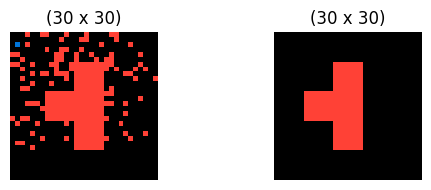

Epoch [2/5], Step [260/400], Loss: 0.3967
Epoch [2/5], Step [270/400], Loss: 0.4032
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 3 4 5 6 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 4 6]


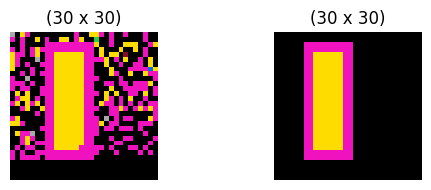

Epoch [2/5], Step [280/400], Loss: 1.1230
Epoch [2/5], Step [290/400], Loss: 0.0656
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 4 6 7 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2 3 4 6 7 8 9]


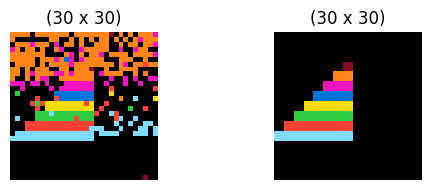

Epoch [2/5], Step [300/400], Loss: 0.8671
Epoch [2/5], Step [310/400], Loss: 0.2952
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 4 7 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 4 9]


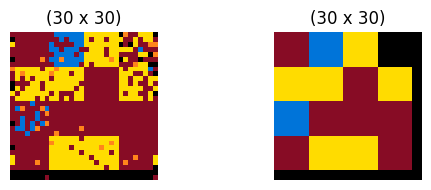

Epoch [2/5], Step [320/400], Loss: 0.5149
Epoch [2/5], Step [330/400], Loss: 1.4159
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2 8]


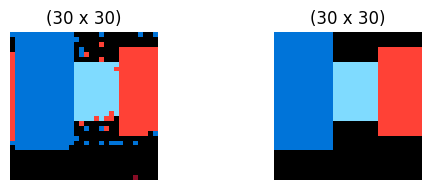

Epoch [2/5], Step [340/400], Loss: 0.4878
Epoch [2/5], Step [350/400], Loss: 0.4553
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 3 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 3]


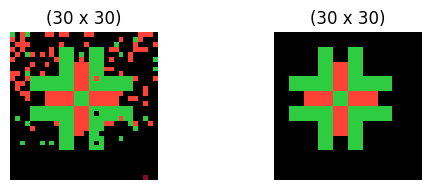

Epoch [2/5], Step [360/400], Loss: 0.7747
Epoch [2/5], Step [370/400], Loss: 0.3772
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 3 6 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 9]


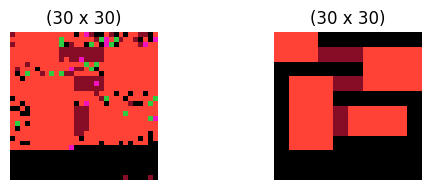

Epoch [2/5], Step [380/400], Loss: 0.6671
Epoch [2/5], Step [390/400], Loss: 0.5474
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 7]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 7]


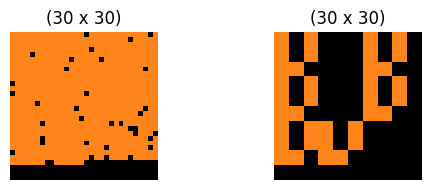

Epoch [3/5], Step [0/400], Loss: 0.2664
Epoch [3/5], Step [10/400], Loss: 0.9173
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 4 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1]


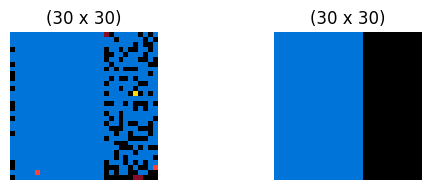

Epoch [3/5], Step [20/400], Loss: 0.2361
Epoch [3/5], Step [30/400], Loss: 0.2849
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 3 4 6 7 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 3 4 7]


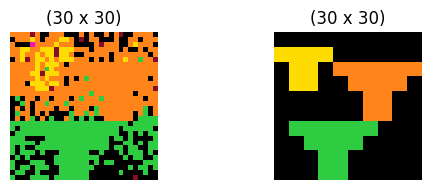

Epoch [3/5], Step [40/400], Loss: 0.4193
Epoch [3/5], Step [50/400], Loss: 0.6029
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 4 5 6 7 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2 3 4 5 6 7 8 9]


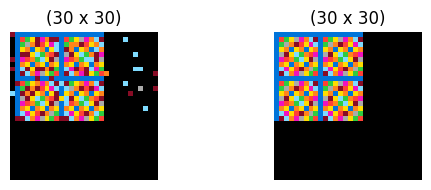

Epoch [3/5], Step [60/400], Loss: 4.0692
Epoch [3/5], Step [70/400], Loss: 0.5069
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 8]


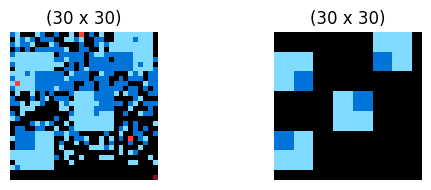

Epoch [3/5], Step [80/400], Loss: 0.7033
Epoch [3/5], Step [90/400], Loss: 1.1032
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2]


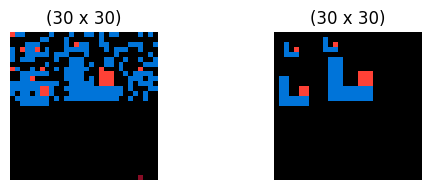

Epoch [3/5], Step [100/400], Loss: 0.5765
Epoch [3/5], Step [110/400], Loss: 0.2307
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 4 6 7 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 7]


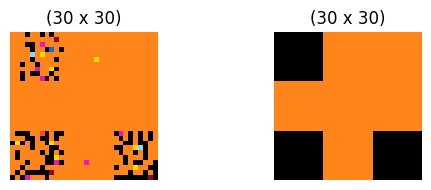

Epoch [3/5], Step [120/400], Loss: 0.1864
Epoch [3/5], Step [130/400], Loss: 0.4634
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 3 6 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 6]


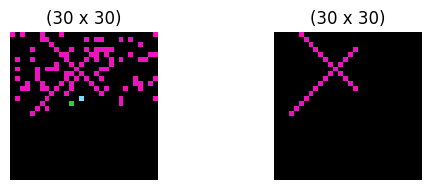

Epoch [3/5], Step [140/400], Loss: 1.0828
Epoch [3/5], Step [150/400], Loss: 0.8534
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 6]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 6]


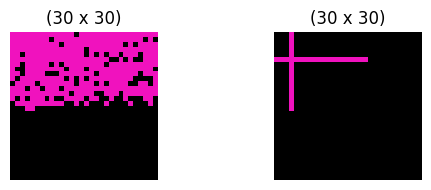

Epoch [3/5], Step [160/400], Loss: 0.6477
Epoch [3/5], Step [170/400], Loss: 0.3667
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 4 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 4 8]


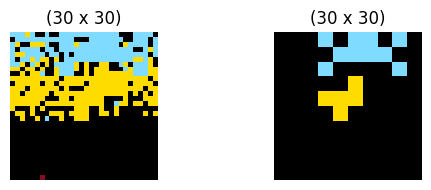

Epoch [3/5], Step [180/400], Loss: 0.5749
Epoch [3/5], Step [190/400], Loss: 1.0798
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 4 5 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 4 8]


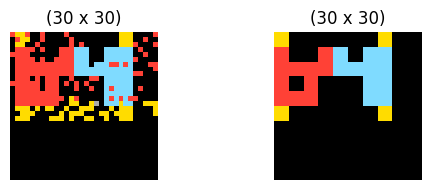

Epoch [3/5], Step [200/400], Loss: 0.6876
Epoch [3/5], Step [210/400], Loss: 0.3732
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 8]


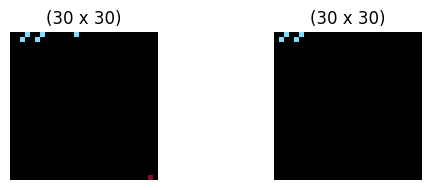

Epoch [3/5], Step [220/400], Loss: 0.1415
Epoch [3/5], Step [230/400], Loss: 0.7960
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 3 5 6 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 3 5 6 8]


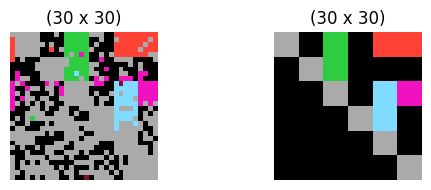

Epoch [3/5], Step [240/400], Loss: 0.8372
Epoch [3/5], Step [250/400], Loss: 0.5144
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2]


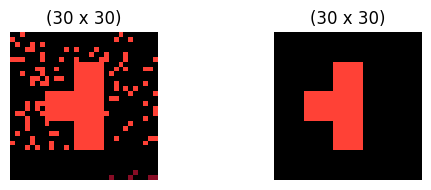

Epoch [3/5], Step [260/400], Loss: 0.3348
Epoch [3/5], Step [270/400], Loss: 0.3685
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 4 5 6]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 4 6]


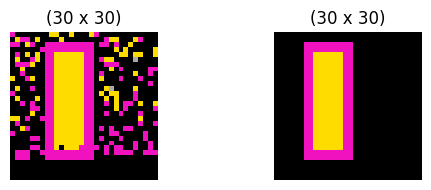

Epoch [3/5], Step [280/400], Loss: 1.0873
Epoch [3/5], Step [290/400], Loss: 0.0368
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 4 6 7 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2 3 4 6 7 8 9]


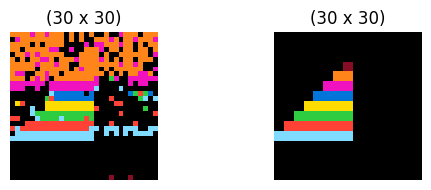

Epoch [3/5], Step [300/400], Loss: 0.7391
Epoch [3/5], Step [310/400], Loss: 0.2756
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 3 4 5 7 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 4 9]


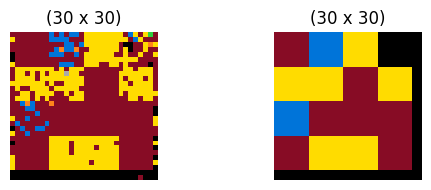

Epoch [3/5], Step [320/400], Loss: 0.4410
Epoch [3/5], Step [330/400], Loss: 1.3470
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2 8]


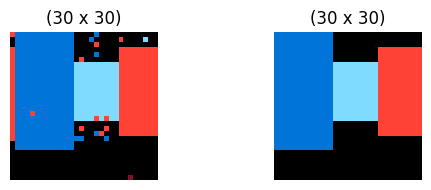

Epoch [3/5], Step [340/400], Loss: 0.4724
Epoch [3/5], Step [350/400], Loss: 0.4470
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 3 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 3]


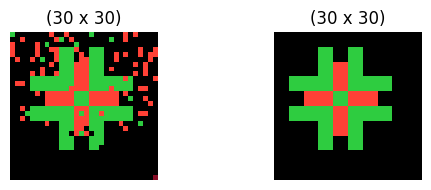

Epoch [3/5], Step [360/400], Loss: 0.7720
Epoch [3/5], Step [370/400], Loss: 0.3447
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 3 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 9]


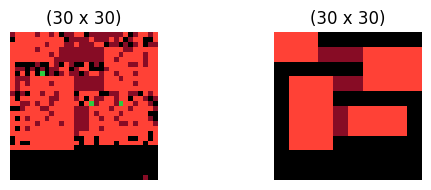

Epoch [3/5], Step [380/400], Loss: 0.5815
Epoch [3/5], Step [390/400], Loss: 0.4591
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 6 7 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 7]


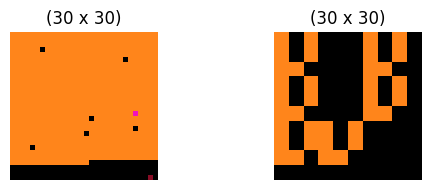

Epoch [4/5], Step [0/400], Loss: 0.2171
Epoch [4/5], Step [10/400], Loss: 0.8613
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1]


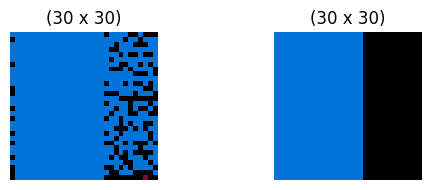

Epoch [4/5], Step [20/400], Loss: 0.1971
Epoch [4/5], Step [30/400], Loss: 0.2425
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 3 4 7 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 3 4 7]


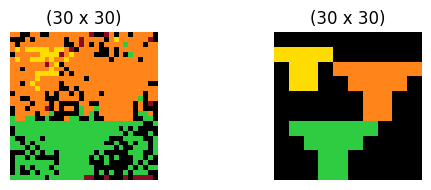

Epoch [4/5], Step [40/400], Loss: 0.4436
Epoch [4/5], Step [50/400], Loss: 0.5650
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 4 5 6 7 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2 3 4 5 6 7 8 9]


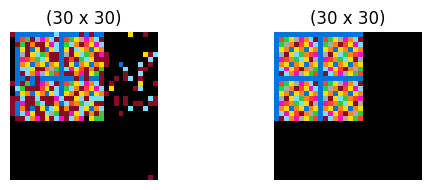

Epoch [4/5], Step [60/400], Loss: 3.6717
Epoch [4/5], Step [70/400], Loss: 0.5172
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 8]


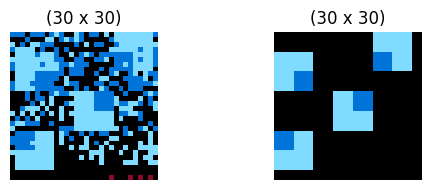

Epoch [4/5], Step [80/400], Loss: 0.6377
Epoch [4/5], Step [90/400], Loss: 1.0017
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2]


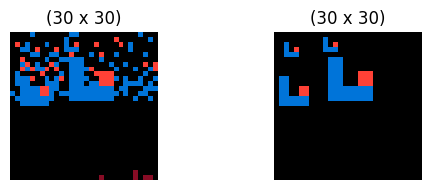

Epoch [4/5], Step [100/400], Loss: 0.5280
Epoch [4/5], Step [110/400], Loss: 0.2447
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 5 6 7 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 7]


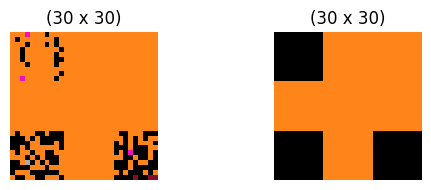

Epoch [4/5], Step [120/400], Loss: 0.1155
Epoch [4/5], Step [130/400], Loss: 0.3531
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 6 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 6]


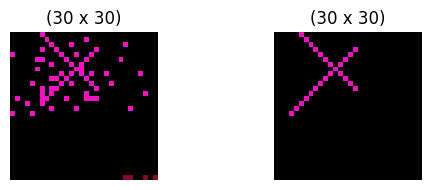

Epoch [4/5], Step [140/400], Loss: 0.9067
Epoch [4/5], Step [150/400], Loss: 0.8392
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 6 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 6]


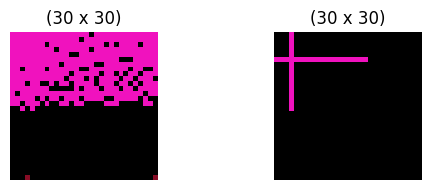

Epoch [4/5], Step [160/400], Loss: 0.5765
Epoch [4/5], Step [170/400], Loss: 0.3139
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 4 5 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 4 8]


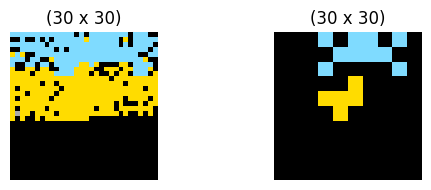

Epoch [4/5], Step [180/400], Loss: 0.5241
Epoch [4/5], Step [190/400], Loss: 0.9443
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 4 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 4 8]


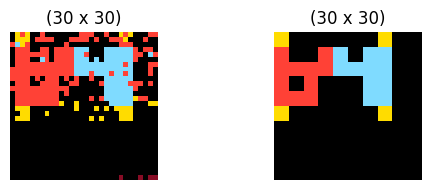

Epoch [4/5], Step [200/400], Loss: 0.6425
Epoch [4/5], Step [210/400], Loss: 0.3213
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 8]


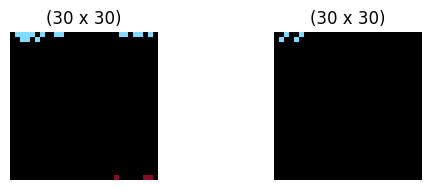

Epoch [4/5], Step [220/400], Loss: 0.1211
Epoch [4/5], Step [230/400], Loss: 0.6301
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 3 5 6 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 3 5 6 8]


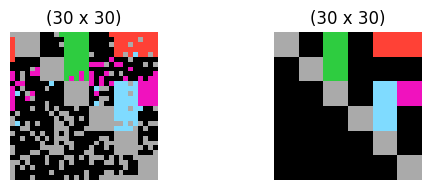

Epoch [4/5], Step [240/400], Loss: 0.7333
Epoch [4/5], Step [250/400], Loss: 0.4994
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2]


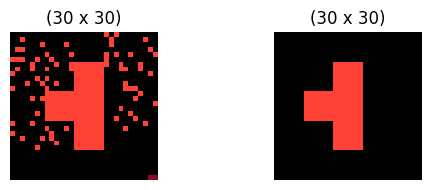

Epoch [4/5], Step [260/400], Loss: 0.2960
Epoch [4/5], Step [270/400], Loss: 0.3422
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 4 6 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 4 6]


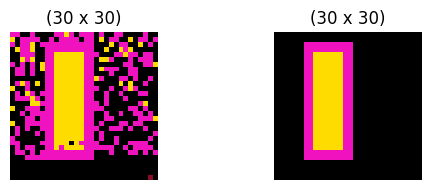

Epoch [4/5], Step [280/400], Loss: 0.8441
Epoch [4/5], Step [290/400], Loss: 0.0173
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 4 6 7 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2 3 4 6 7 8 9]


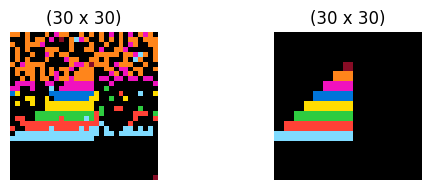

Epoch [4/5], Step [300/400], Loss: 0.6086
Epoch [4/5], Step [310/400], Loss: 0.1455
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 4 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 4 9]


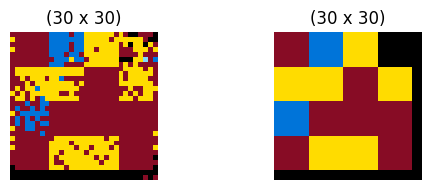

Epoch [4/5], Step [320/400], Loss: 0.3896
Epoch [4/5], Step [330/400], Loss: 1.3753
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2 8]


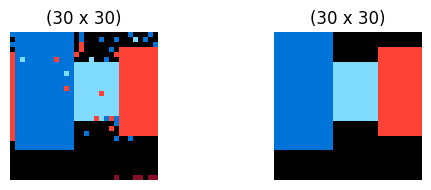

Epoch [4/5], Step [340/400], Loss: 0.4464
Epoch [4/5], Step [350/400], Loss: 0.4213
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 3 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 3]


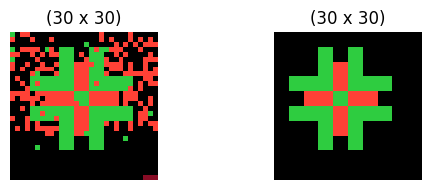

Epoch [4/5], Step [360/400], Loss: 0.7199
Epoch [4/5], Step [370/400], Loss: 0.2870
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 3 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 9]


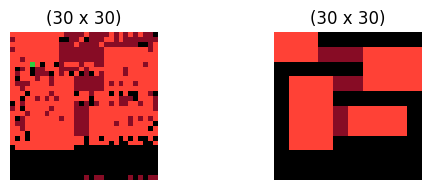

Epoch [4/5], Step [380/400], Loss: 0.5325
Epoch [4/5], Step [390/400], Loss: 0.4117
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 7]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 7]


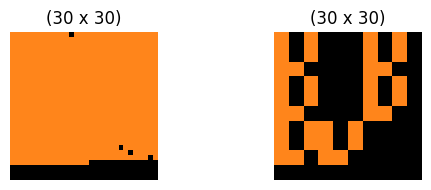

Epoch [5/5], Step [0/400], Loss: 0.2124
Epoch [5/5], Step [10/400], Loss: 0.7979
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1]


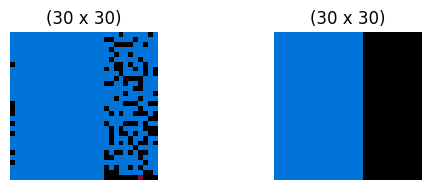

Epoch [5/5], Step [20/400], Loss: 0.1757
Epoch [5/5], Step [30/400], Loss: 0.2224
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 3 4 7 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 3 4 7]


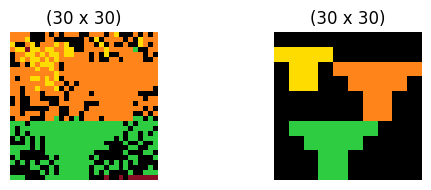

Epoch [5/5], Step [40/400], Loss: 0.3375
Epoch [5/5], Step [50/400], Loss: 0.5295
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 4 5 6 7 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2 3 4 5 6 7 8 9]


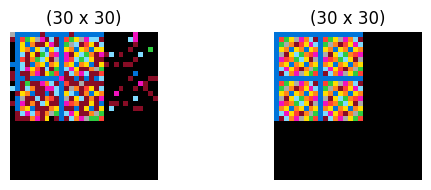

Epoch [5/5], Step [60/400], Loss: 3.5447
Epoch [5/5], Step [70/400], Loss: 0.4646
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 7 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 8]


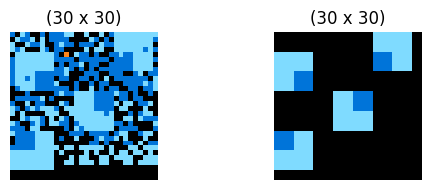

Epoch [5/5], Step [80/400], Loss: 0.6804
Epoch [5/5], Step [90/400], Loss: 0.8237
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2]


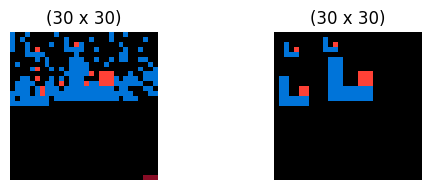

Epoch [5/5], Step [100/400], Loss: 0.4853
Epoch [5/5], Step [110/400], Loss: 0.2132
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 7 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 7]


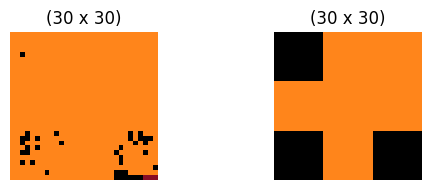

Epoch [5/5], Step [120/400], Loss: 0.0719
Epoch [5/5], Step [130/400], Loss: 0.3632
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 6]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 6]


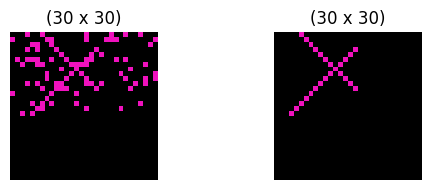

Epoch [5/5], Step [140/400], Loss: 0.8168
Epoch [5/5], Step [150/400], Loss: 0.7379
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 6]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 6]


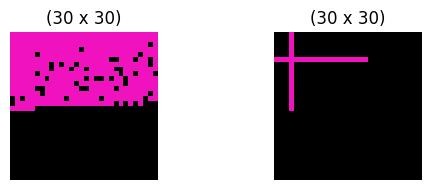

Epoch [5/5], Step [160/400], Loss: 0.6570
Epoch [5/5], Step [170/400], Loss: 0.2993
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 4 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 4 8]


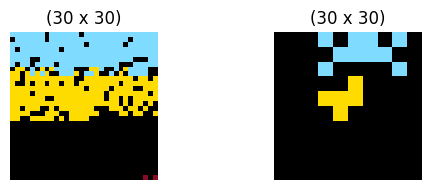

Epoch [5/5], Step [180/400], Loss: 0.4513
Epoch [5/5], Step [190/400], Loss: 0.9318
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 4 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 4 8]


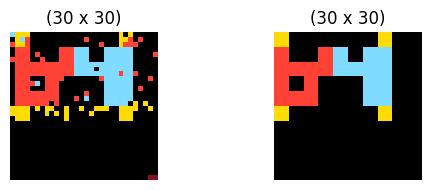

Epoch [5/5], Step [200/400], Loss: 0.5938
Epoch [5/5], Step [210/400], Loss: 0.3180
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 8]


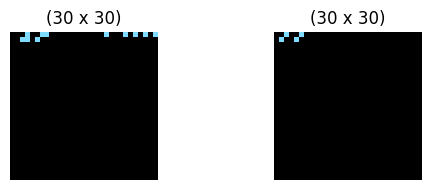

Epoch [5/5], Step [220/400], Loss: 0.1828
Epoch [5/5], Step [230/400], Loss: 0.5835
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 3 5 6 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 3 5 6 8]


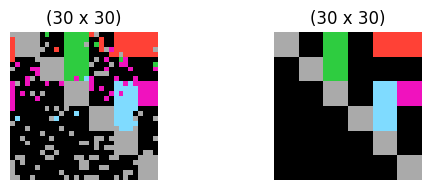

Epoch [5/5], Step [240/400], Loss: 0.6728
Epoch [5/5], Step [250/400], Loss: 0.4421
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2]


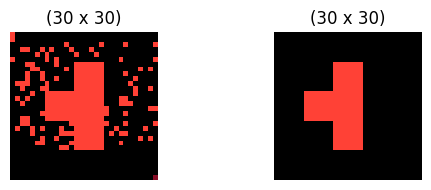

Epoch [5/5], Step [260/400], Loss: 0.2782
Epoch [5/5], Step [270/400], Loss: 0.3176
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 4 6]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 4 6]


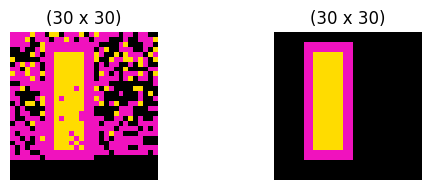

Epoch [5/5], Step [280/400], Loss: 0.8789
Epoch [5/5], Step [290/400], Loss: 0.0183
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 4 6 7 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2 3 4 6 7 8 9]


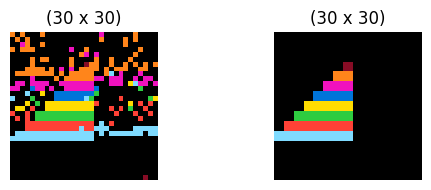

Epoch [5/5], Step [300/400], Loss: 0.5442
Epoch [5/5], Step [310/400], Loss: 0.1439
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 4 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 4 9]


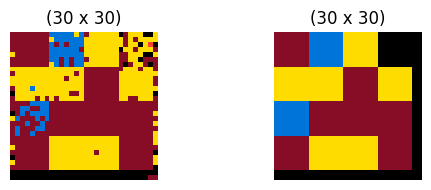

Epoch [5/5], Step [320/400], Loss: 0.3806
Epoch [5/5], Step [330/400], Loss: 1.3976
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2 8]


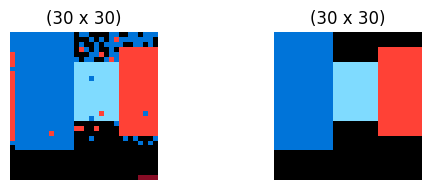

Epoch [5/5], Step [340/400], Loss: 0.4155
Epoch [5/5], Step [350/400], Loss: 0.4639
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 3 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 3]


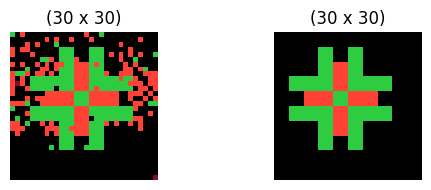

Epoch [5/5], Step [360/400], Loss: 0.7027
Epoch [5/5], Step [370/400], Loss: 0.3332
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 9]


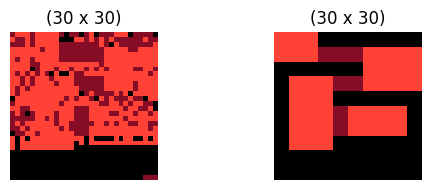

Epoch [5/5], Step [380/400], Loss: 0.5392
Epoch [5/5], Step [390/400], Loss: 0.3490


In [64]:
num_epochs = 5
# torch.set_printoption(edgeitems=10)

train_model(train_data, model, criterion, optimizer, num_epochs)

In [65]:
if KAGGLE:
    torch.save(model.state_dict(), '/kaggle/working/arc_categorical_avg_model.pth')
else:
    torch.save(model.state_dict(), './models/arc_categorical_avg_model.pth')

In [66]:
saved_model = CustomTransformerCategorical(
    256,  # Match the embedding dimension
    num_categories,
    nhead=4,  # 8,6,6
    num_encoder_layers=4,
    num_decoder_layers=4,
    dim_feedforward=2048,
).to(DEVICE)

if KAGGLE:
    saved_model.load_state_dict(torch.load('/kaggle/working/arc_categorical_avg_model.pth'))
else:
    saved_model.load_state_dict(torch.load('./models/arc_categorical_avg_model.pth'))

saved_model.to(DEVICE)

/home/gyc/.pyenv/versions/kaggle/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


CustomTransformerCategorical(
  (grid_embedding): Embedding(13, 256)
  (grid_positional_encoding): PositionalEncoding()
  (grid_positional_encoding_inference): PositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerDecoderLayer(
        (se

===== 00576224 =====
encoder length: 2, decoder shape: torch.Size([902])
(900,)
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [4 6 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [4 6 8]


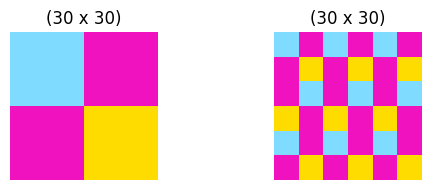

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [3 4 7 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [3 4 7 9]


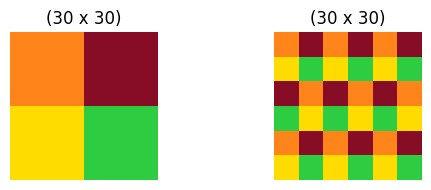

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [2 3 7 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [7]
Matrix 2 shape: (30, 30)
Unique values in matrix 2: [2 3 7 8]


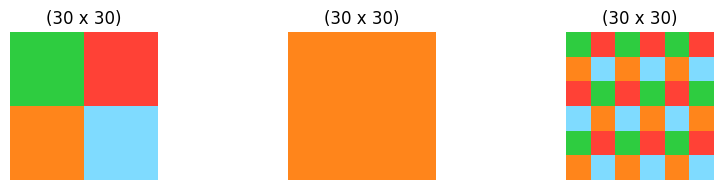


===== 009d5c81 =====
encoder length: 5, decoder shape: torch.Size([902])
(900,)
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2]


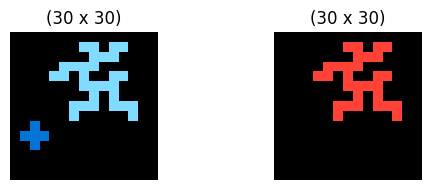

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 3]


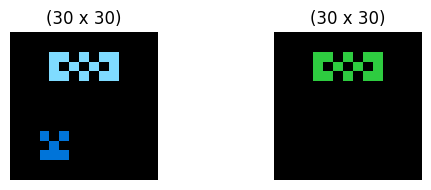

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2]


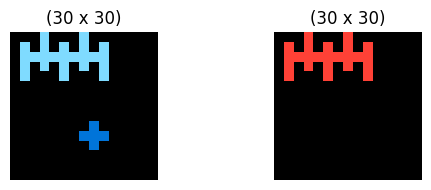

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 7]


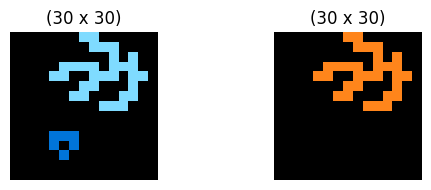

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 3]


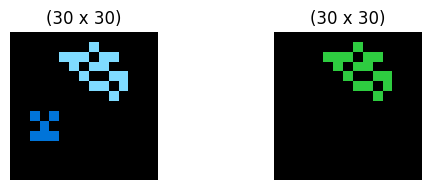

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [8]
Matrix 2 shape: (30, 30)
Unique values in matrix 2: [0 7]


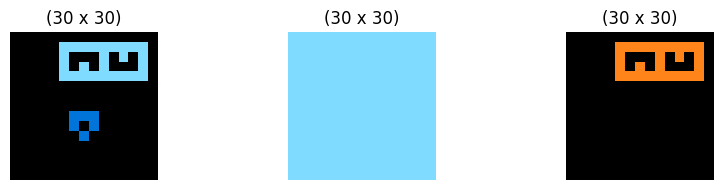


===== 00dbd492 =====
encoder length: 4, decoder shape: torch.Size([902])
(900,)
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 8]


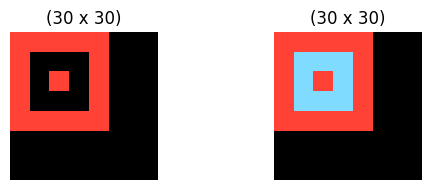

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 4]


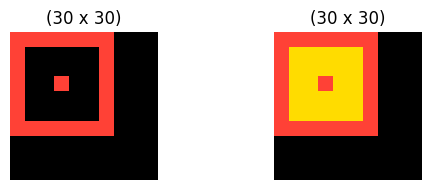

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 3 8]


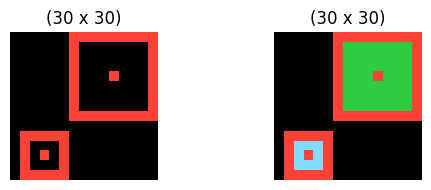

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 4 8]


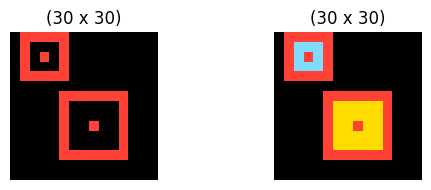

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [2]
Matrix 2 shape: (30, 30)
Unique values in matrix 2: [0 2 3 4 8]


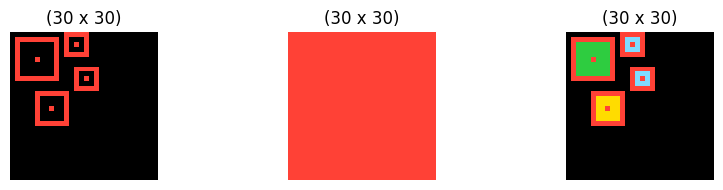


===== 03560426 =====
encoder length: 3, decoder shape: torch.Size([902])
(900,)
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 4]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2 3 4]


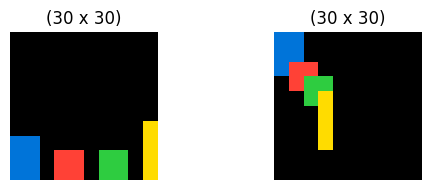

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 7 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 7 8]


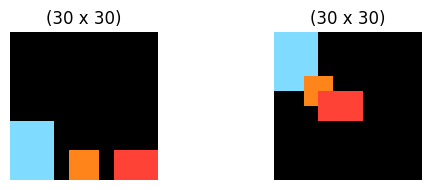

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 3 4]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 3 4]


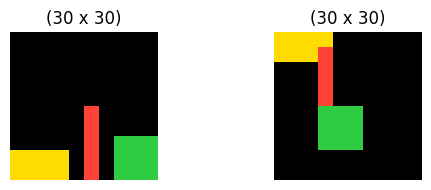

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 3 6 7 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [7]
Matrix 2 shape: (30, 30)
Unique values in matrix 2: [0 3 6 7 8]


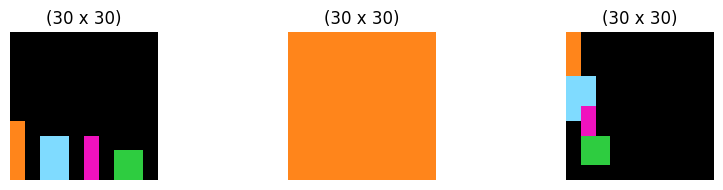


===== 05a7bcf2 =====
encoder length: 3, decoder shape: torch.Size([902])
(900,)
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 4 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 3 4 8]


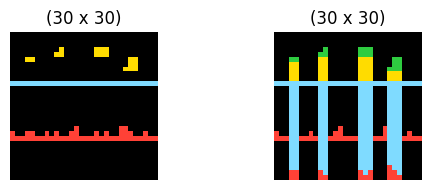

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 4 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 3 4 8]


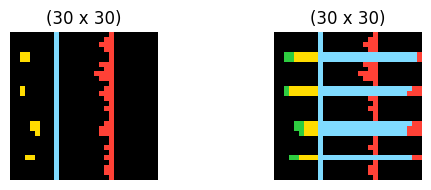

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 4 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 3 4 8]


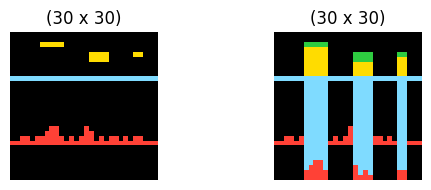

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 4 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [8]
Matrix 2 shape: (30, 30)
Unique values in matrix 2: [0 2 3 4 8]


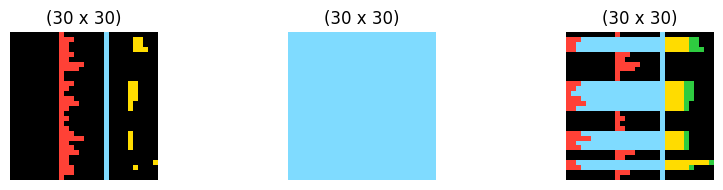


===== 0607ce86 =====
encoder length: 3, decoder shape: torch.Size([902])
(900,)
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 3 6 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 3 6 8]


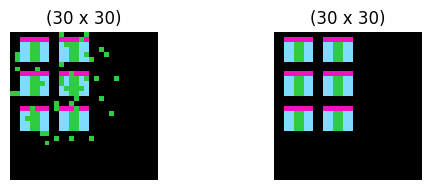

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2 3 8]


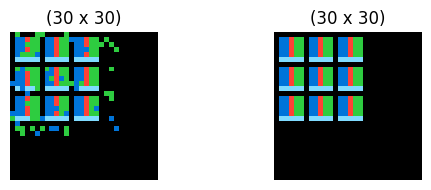

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2 3]


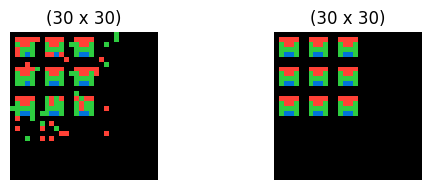

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 3 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [8]
Matrix 2 shape: (30, 30)
Unique values in matrix 2: [0 2 3 8]


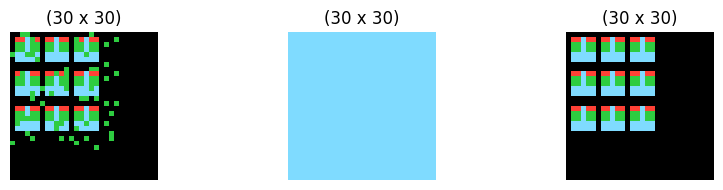


===== 0692e18c =====
encoder length: 3, decoder shape: torch.Size([902])
(900,)
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 7]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 7]


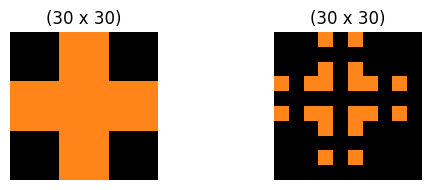

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 6]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 6]


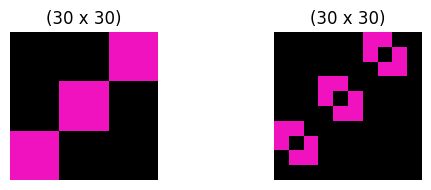

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 4]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 4]


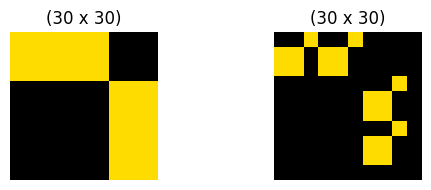

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 3]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [3]
Matrix 2 shape: (30, 30)
Unique values in matrix 2: [0 3]


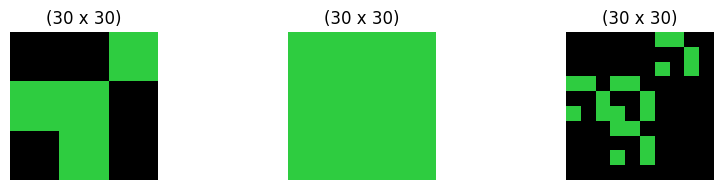


===== 070dd51e =====
encoder length: 2, decoder shape: torch.Size([902])
(900,)
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 3 5 6 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 3 5 6 8]


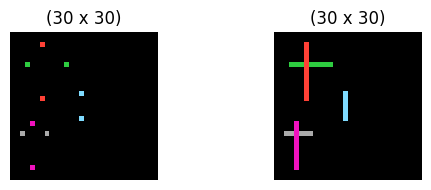

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 3 4 7 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 3 4 7 8 9]


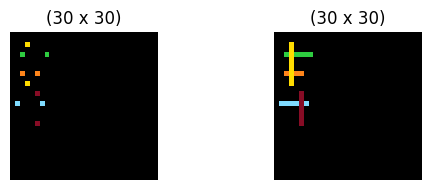

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 3 5 7 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0]
Matrix 2 shape: (30, 30)
Unique values in matrix 2: [0 2 3 5 7 8]


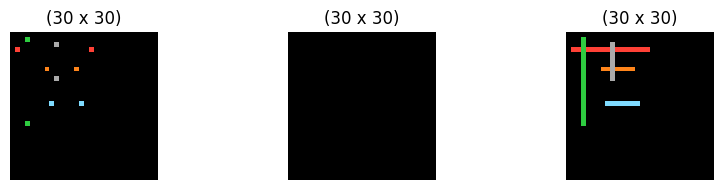


===== 08573cc6 =====
encoder length: 3, decoder shape: torch.Size([902])
(900,)
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 5 6]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 5 6]


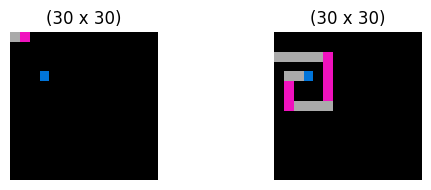

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2 3]


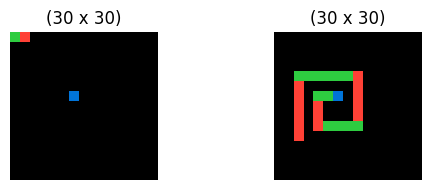

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 3 5]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 3 5]


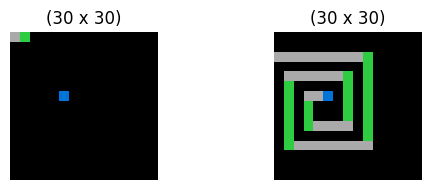

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0]
Matrix 2 shape: (30, 30)
Unique values in matrix 2: [0 1 2 8]


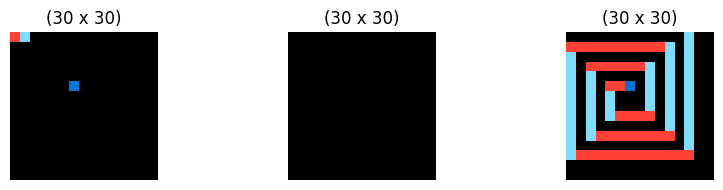


===== 0934a4d8 =====
encoder length: 4, decoder shape: torch.Size([902])
(900,)
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [1 2 3 4 5 6 7 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 3 4 6 9]


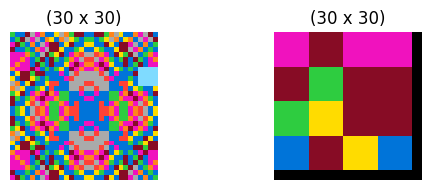

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [1 2 3 4 5 6 7 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2 3 4 5 6]


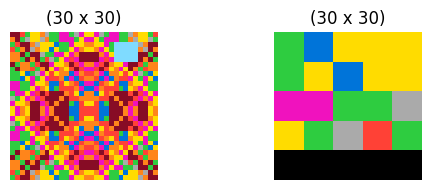

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [1 2 3 4 5 6 7 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2 3 4 6 9]


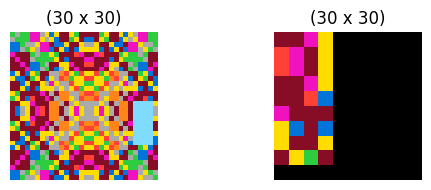

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [1 2 3 4 5 6 7 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 3 4 6 7 9]


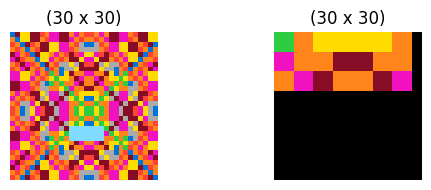

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [1 2 3 4 5 6 7 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [7]
Matrix 2 shape: (30, 30)
Unique values in matrix 2: [0 1 2 4 6 7 9]


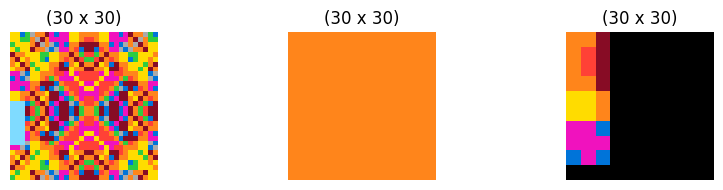


===== 09c534e7 =====
encoder length: 3, decoder shape: torch.Size([902])
(900,)
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2 3]


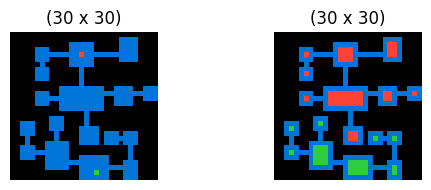

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 4]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2 3 4]


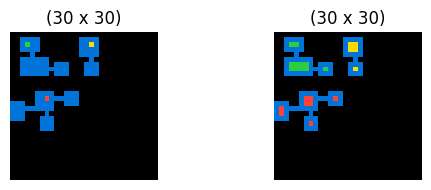

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 3 4 6]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 3 4 6]


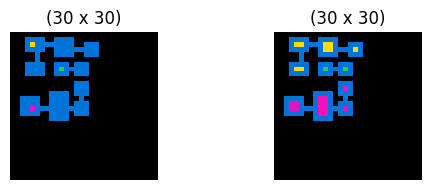

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 4 6 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [1]
Matrix 2 shape: (30, 30)
Unique values in matrix 2: [0 1 4 6 8]


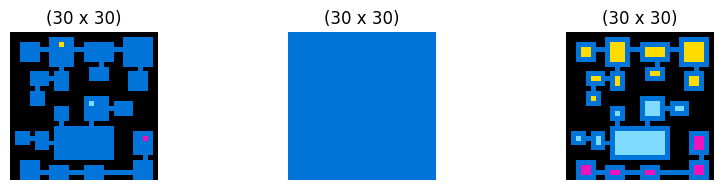


===== 0a1d4ef5 =====
encoder length: 3, decoder shape: torch.Size([902])
(900,)
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 4 5 7 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [1 3 4 7 8]


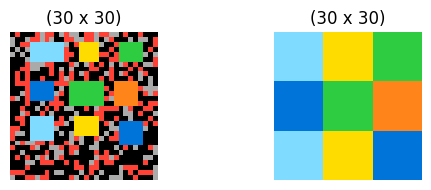

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 4 6 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 3 4 6 9]


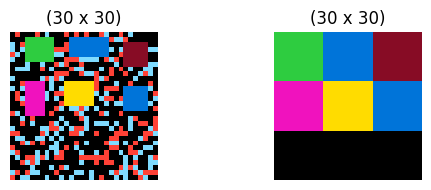

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 4 7 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [2 3 4 7 8]


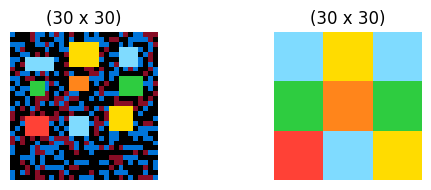

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 4 5 6 7 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [7]
Matrix 2 shape: (30, 30)
Unique values in matrix 2: [0 1 2 3 4 6 7]


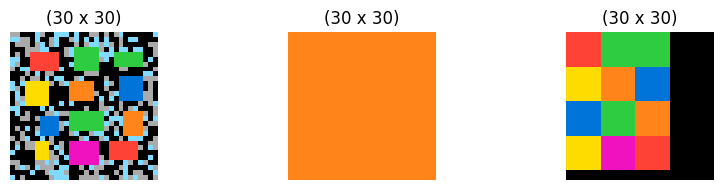


===== 0a2355a6 =====
encoder length: 4, decoder shape: torch.Size([902])
(900,)
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 3]


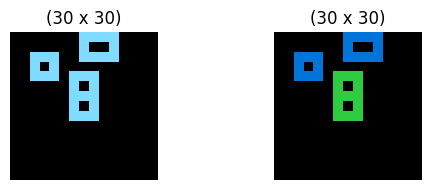

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2 3]


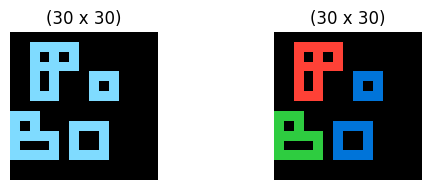

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2 3]


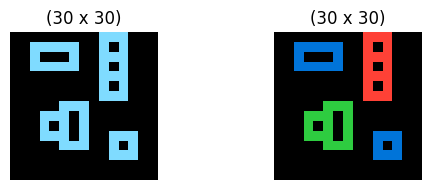

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2 3 4]


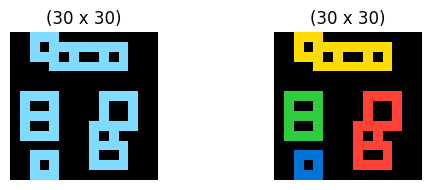

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [8]
Matrix 2 shape: (30, 30)
Unique values in matrix 2: [0 1 2 3 4]


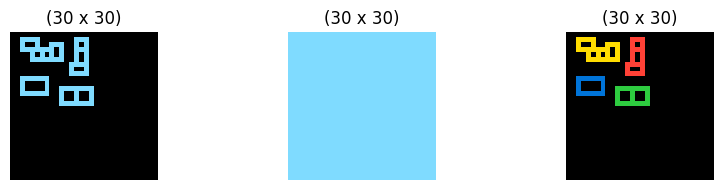


===== 0b17323b =====
encoder length: 2, decoder shape: torch.Size([902])
(900,)
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2]


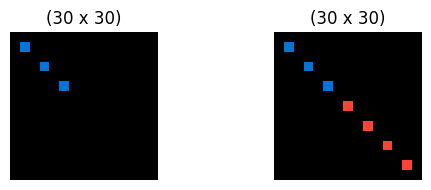

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2]


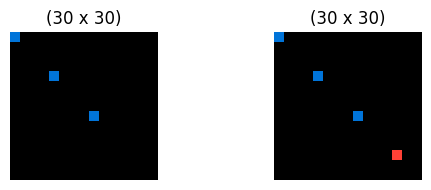

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0]
Matrix 2 shape: (30, 30)
Unique values in matrix 2: [0 1 2]


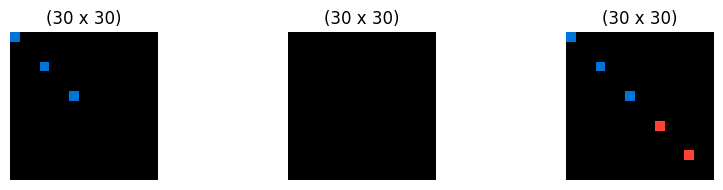


===== 0bb8deee =====
encoder length: 3, decoder shape: torch.Size([902])
(900,)
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 4 5]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 3 4 5]


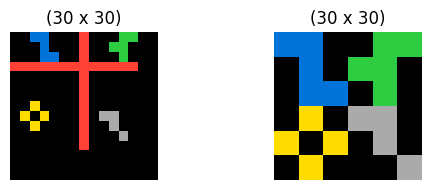

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 5 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 3 5 8]


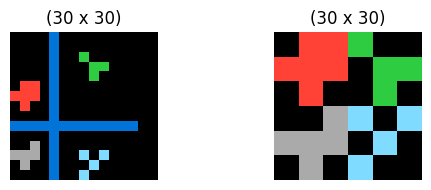

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 4 5]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2 4 5]


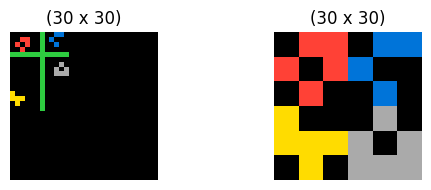

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 4 6]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [1]
Matrix 2 shape: (30, 30)
Unique values in matrix 2: [0 2 3 4 6]


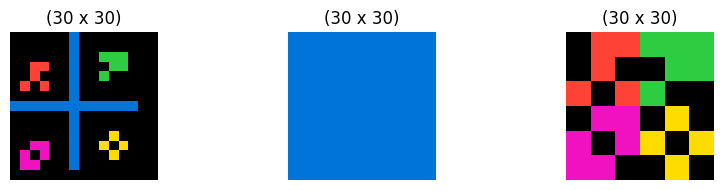


===== 0becf7df =====
encoder length: 3, decoder shape: torch.Size([902])
(900,)
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 3 4 7]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 3 4 7]


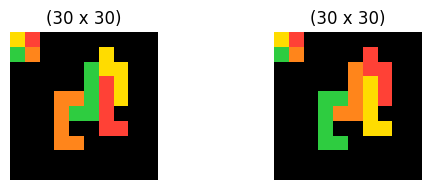

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2 3 8]


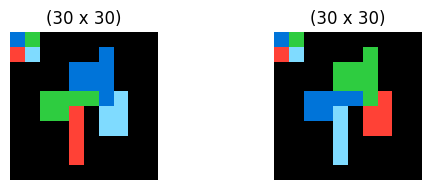

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 4 6 7 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 4 6 7 9]


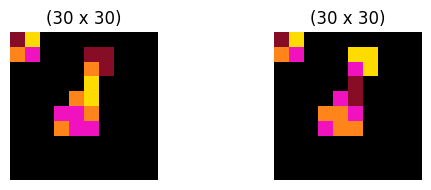

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 4 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [9]
Matrix 2 shape: (30, 30)
Unique values in matrix 2: [0 2 4 8 9]


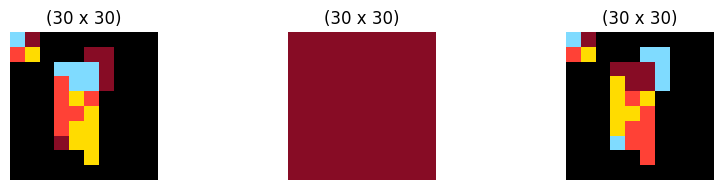


===== 0c786b71 =====
encoder length: 3, decoder shape: torch.Size([902])
(900,)
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 4 6]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 4 6]


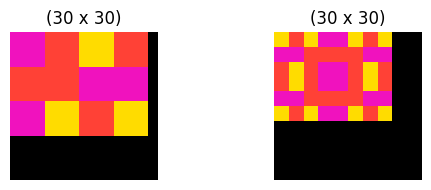

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 5 7 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 5 7 9]


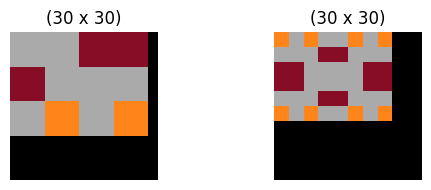

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 3 5 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 3 5 8]


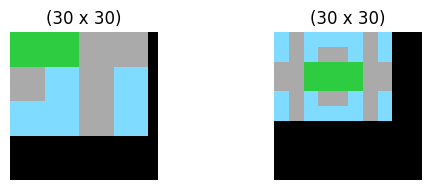

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 5 7 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [7]
Matrix 2 shape: (30, 30)
Unique values in matrix 2: [0 5 7 8]


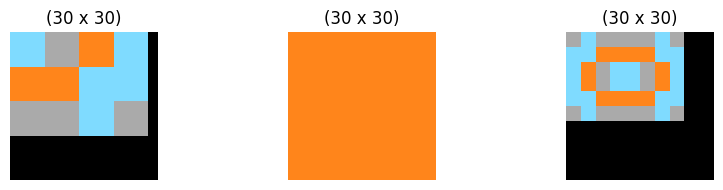


===== 0c9aba6e =====
encoder length: 4, decoder shape: torch.Size([902])
(900,)
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 6 7]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 8]


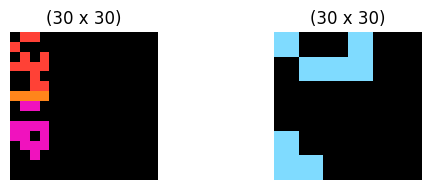

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 6 7]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 8]


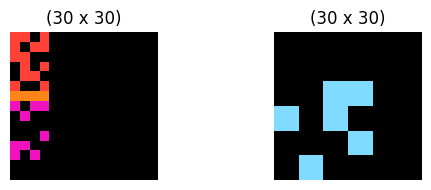

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 6 7]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 8]


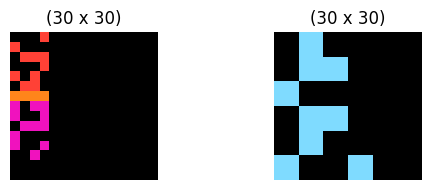

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 6 7]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 8]


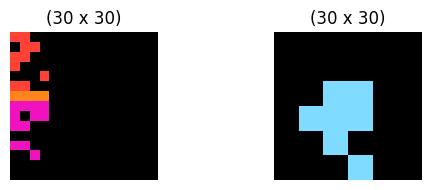

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 6 7]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [6]
Matrix 2 shape: (30, 30)
Unique values in matrix 2: [0 8]


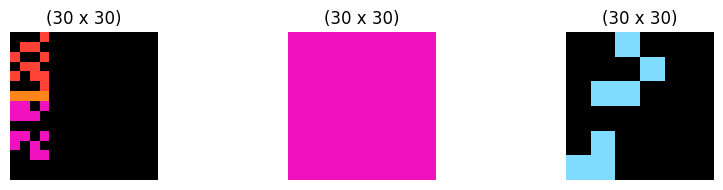


===== 0d87d2a6 =====
encoder length: 3, decoder shape: torch.Size([902])
(900,)
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2]


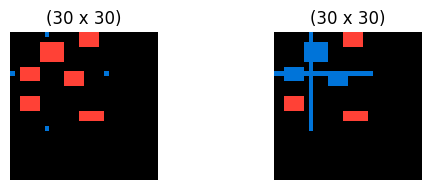

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2]


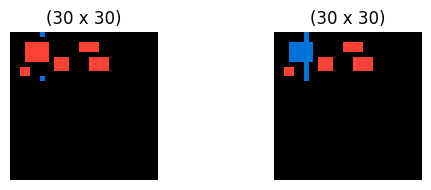

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2]


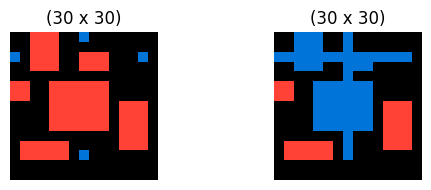

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [2]
Matrix 2 shape: (30, 30)
Unique values in matrix 2: [0 1 2]


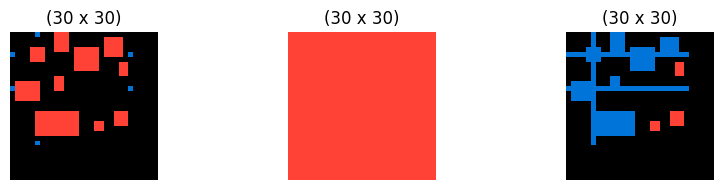


===== 0e671a1a =====
encoder length: 4, decoder shape: torch.Size([902])
(900,)
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 3 4]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 3 4 5]


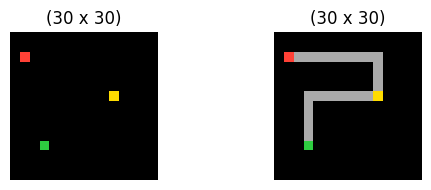

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 3 4]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 3 4 5]


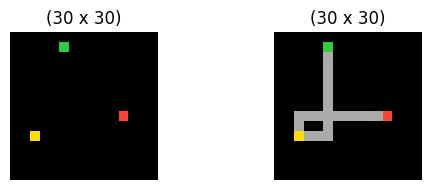

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 3 4]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 3 4 5]


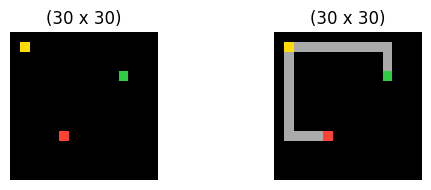

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 3 4]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 3 4 5]


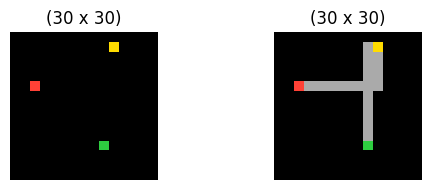

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 3 4]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0]
Matrix 2 shape: (30, 30)
Unique values in matrix 2: [0 2 3 4 5]


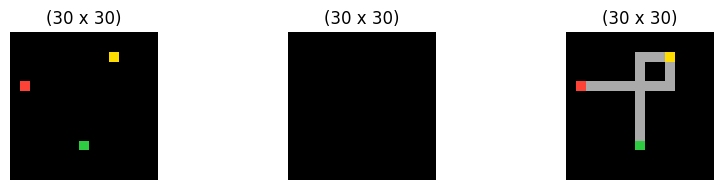


===== 0f63c0b9 =====
encoder length: 4, decoder shape: torch.Size([902])
(900,)
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 6 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 6 8]


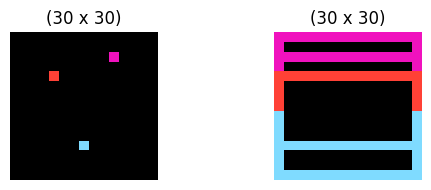

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2 3 8]


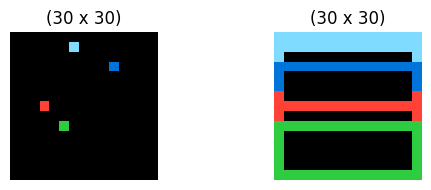

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 7 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 7 8]


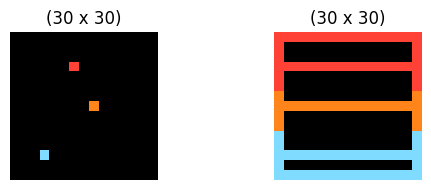

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 3 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 3 9]


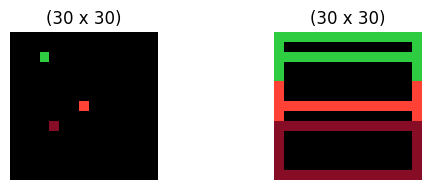

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0]
Matrix 2 shape: (30, 30)
Unique values in matrix 2: [0 1 2 3 8]


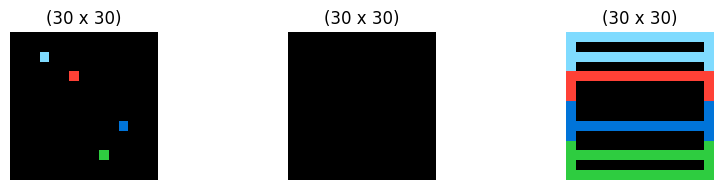


===== 103eff5b =====
encoder length: 2, decoder shape: torch.Size([902])
(900,)
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 4 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2 3 4]


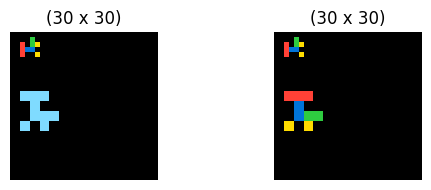

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 4 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2 3 4]


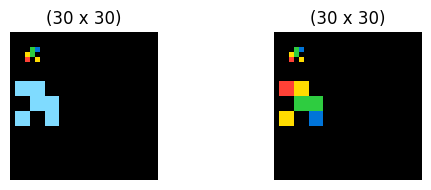

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 3 4 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [8]
Matrix 2 shape: (30, 30)
Unique values in matrix 2: [0 2 3 4]


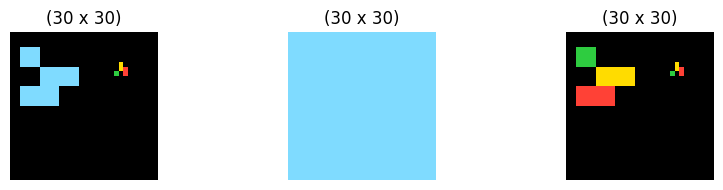


===== 11e1fe23 =====
encoder length: 2, decoder shape: torch.Size([902])
(900,)
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2 3 5]


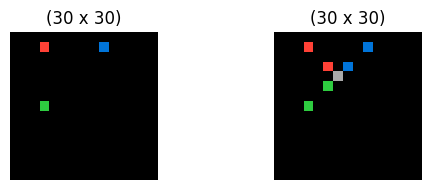

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 6 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 5 6 8]


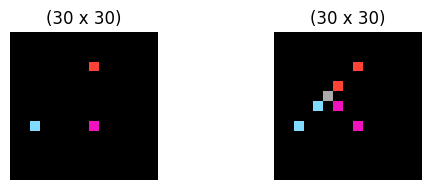

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 3 8 9]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0]
Matrix 2 shape: (30, 30)
Unique values in matrix 2: [0 3 5 8 9]


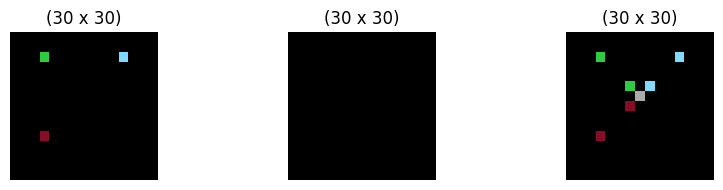


===== 12422b43 =====
encoder length: 5, decoder shape: torch.Size([902])
(900,)
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 4 5 6]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 4 5 6]


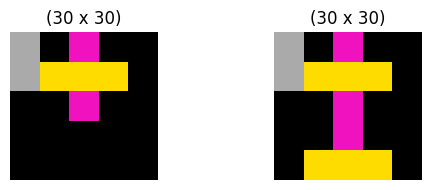

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 3 4 5 7 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 3 4 5 7 8]


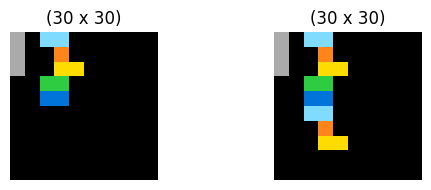

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 3 4 5 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 3 4 5 8]


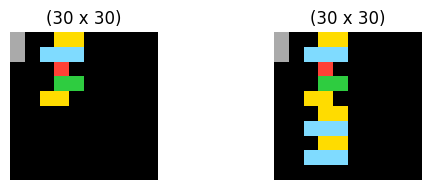

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 3 5 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 3 5 8]


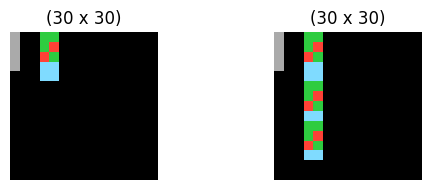

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 3 5 6 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 3 5 6 8]


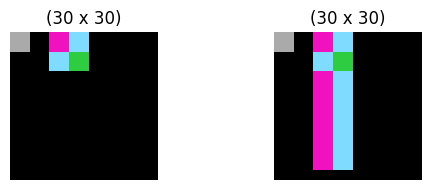

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 4 5 6 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [6]
Matrix 2 shape: (30, 30)
Unique values in matrix 2: [0 2 4 5 6 8]


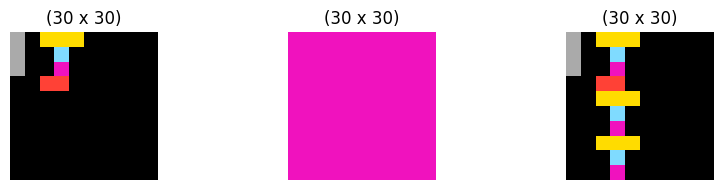


===== 12997ef3 =====
encoder length: 4, decoder shape: torch.Size([902])
(900,)
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 4]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 3 4]


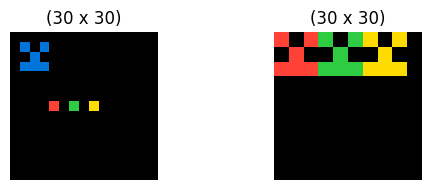

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 3 6 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 3 6 8]


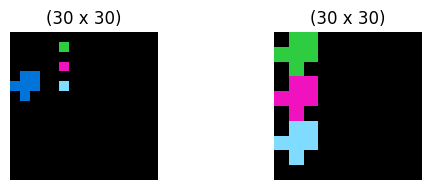

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 3]


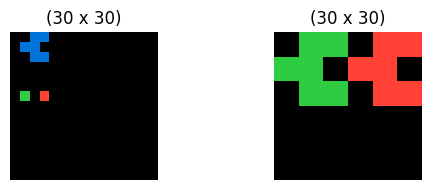

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 6]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 6]


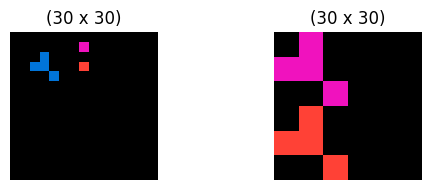

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 6 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0]
Matrix 2 shape: (30, 30)
Unique values in matrix 2: [0 2 3 6 8]


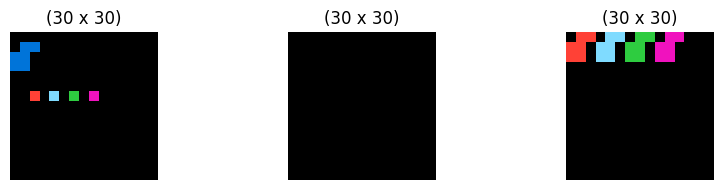


===== 12eac192 =====
encoder length: 4, decoder shape: torch.Size([902])
(900,)
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 5 7 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 3 5 7 8]


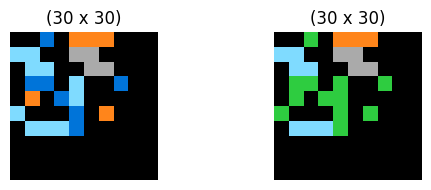

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 5 7 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 3 7 8]


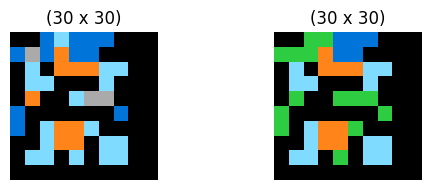

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 5 7 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 3 7]


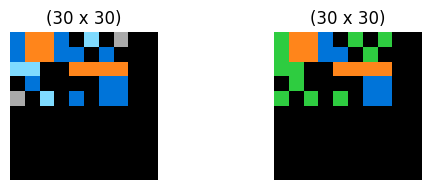

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 5 7]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 3 7]


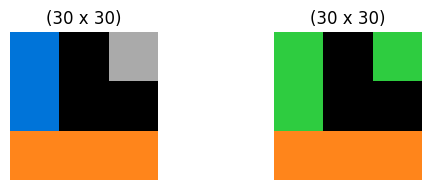

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 5 7]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [7]
Matrix 2 shape: (30, 30)
Unique values in matrix 2: [0 1 3 5 7]


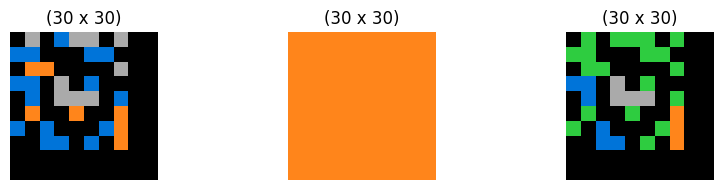


===== 136b0064 =====
encoder length: 3, decoder shape: torch.Size([902])
(900,)
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 4 5 6]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2 3 5 6]


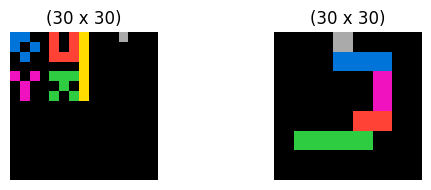

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 4 5 6]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2 3 5 6]


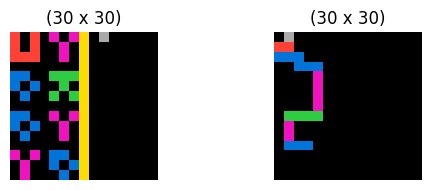

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 4 5 6]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 1 2 5 6]


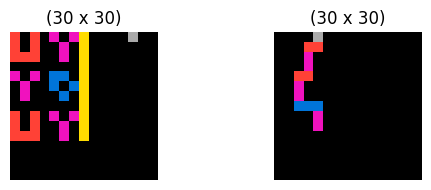

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 1 2 3 4 5 6]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0]
Matrix 2 shape: (30, 30)
Unique values in matrix 2: [0 1 2 3 5 6]


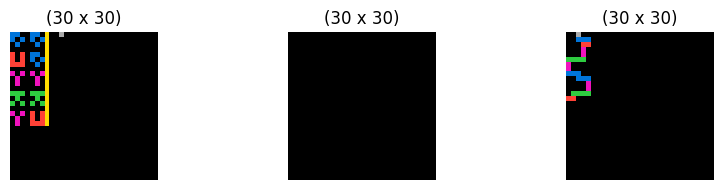


===== 13713586 =====
encoder length: 3, decoder shape: torch.Size([902])
(900,)
Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 3 4 5 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 3 4 5 8]


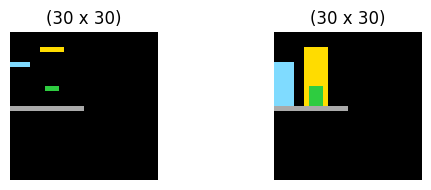

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 3 5 7]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 3 5 7]


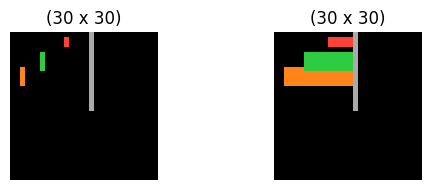

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 3 5 6]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [0 2 3 5 6]


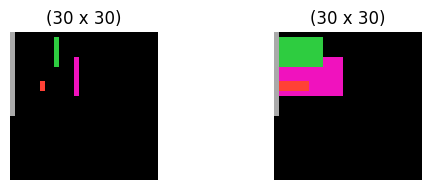

Matrix 0 shape: (30, 30)
Unique values in matrix 0: [0 2 3 4 5 8]
Matrix 1 shape: (30, 30)
Unique values in matrix 1: [5]
Matrix 2 shape: (30, 30)
Unique values in matrix 2: [0 2 3 4 5 8]


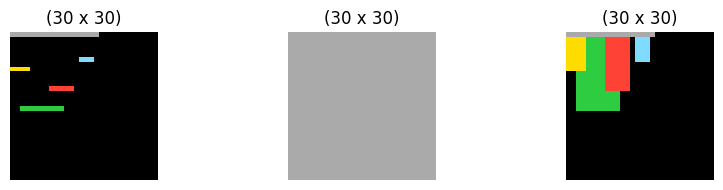


===== 137f0df0 =====
encoder length: 3, decoder shape: torch.Size([902])


KeyboardInterrupt: 

In [78]:
def inference(data: dict):
    # Encoder data
    encoder_inputs = [custom_zoom(np.array(x['input'], dtype=np.int32)) for x in data['train']]
    encoder_outputs = [custom_zoom(np.array(x['output'], dtype=np.int32)) for x in data['train']]

    # List[num_samples, seq_length]
    encoder_tokens = prepare_encoder_data_with_tokens(encoder_inputs, encoder_outputs)

    # Decoder data
    decoder_inputs = custom_zoom(np.array(data['test'][0]['input'], dtype=np.int32))
    decoder_tokens = prepare_inference_data_with_special_tokens(decoder_inputs)

    print(f"encoder length: {len(encoder_tokens)}, decoder shape: {decoder_tokens.shape}")
    output = saved_model.predict(encoder_tokens, decoder_tokens)

    output_grid = np.array(output[decoder_tokens.shape[0]:-1])
    print(output_grid.shape)

    for si, so in zip(encoder_inputs, encoder_outputs):
        paint(si, so)

    paint(
        decoder_inputs,
        output_grid.reshape(30, 30),
        custom_zoom(np.array(data['test'][0]['output'], dtype=np.int32))
    )

    return output

for task_id, task_data in val_data.items():
    print(f'===== {task_id} =====')
    inference(task_data)
    print()
